In [7]:
# Google Drive Connect
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
# Dataset Zip file Extract
import zipfile
import os

zip_path = "/content/drive/MyDrive/Data.zip"  # Pathway
extract_path = "/content/data"  # Pathway

# Zip file Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to {extract_path}")

# Directory Structure
for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}")
    for file in files[:5]:  # Max 5 files
        print(f"  File: {file}")

Dataset extracted to /content/data
Directory: /content/data
Directory: /content/data/Data
Directory: /content/data/Data/test
Directory: /content/data/Data/test/mask
  File: 5.png
  File: 19.png
  File: 2.png
  File: 7.png
  File: 8.png
Directory: /content/data/Data/test/image
  File: 5.png
  File: 19.png
  File: 2.png
  File: 7.png
  File: 8.png
Directory: /content/data/Data/train
Directory: /content/data/Data/train/mask
  File: 5.png
  File: 21.png
  File: 46.png
  File: 69.png
  File: 74.png
Directory: /content/data/Data/train/image
  File: 5.png
  File: 21.png
  File: 46.png
  File: 69.png
  File: 74.png
Directory: /content/data/__MACOSX
  File: ._Data
Directory: /content/data/__MACOSX/Data
  File: ._test
  File: ._train
Directory: /content/data/__MACOSX/Data/test
  File: ._image
  File: ._mask
Directory: /content/data/__MACOSX/Data/test/mask
  File: ._7.png
  File: ._2.png
  File: ._12.png
  File: ._19.png
  File: ._18.png
Directory: /content/data/__MACOSX/Data/test/image
  File: .

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import trange

# Define Dataset Class
class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_list = sorted(os.listdir(image_dir))
        self.mask_list = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # Load Image & Mask files
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Change Mask into Binary
        mask = (mask > 0).float()  # 0 or 1
        return image, mask

# 데이터 경로 설정
TRAIN_IMAGE_PATH = os.path.join(extract_path, "Data/train/image")
TRAIN_MASK_PATH = os.path.join(extract_path, "Data/train/mask")
TEST_IMAGE_PATH = os.path.join(extract_path, "Data/test/image")
TEST_MASK_PATH = os.path.join(extract_path, "Data/test/mask")

# 데이터 변환
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# 데이터 로더 준비
train_dataset = RetinaDataset(TRAIN_IMAGE_PATH, TRAIN_MASK_PATH, transform=transform)
test_dataset = RetinaDataset(TEST_IMAGE_PATH, TEST_MASK_PATH, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

def patchify(x, patch_size):
    """
    x: (N, C, H, W)
    Return:
       patches: (N, num_patches, C, patch_size, patch_size)
    """
    N, C, H, W = x.shape
    assert H % patch_size == 0 and W % patch_size == 0, \
        "Image dimensions must be divisible by patch_size."

    # Get the patches via unfolding
    patches = x.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    # patches shape => (N, C, H//p, W//p, p, p)

    # Rearrange to (N, (H//p)*(W//p), C, p, p)
    patches = patches.permute(0, 2, 3, 1, 4, 5)  # (N, H//p, W//p, C, p, p)
    N, HP, WP, C, pH, pW = patches.shape
    patches = patches.reshape(N, HP*WP, C, pH, pW)
    return patches

def unpatchify(patches, patch_size, img_height, img_width):
    """
    patches: (N, num_patches, C, patch_size, patch_size)
    Reconstruct: (N, C, img_height, img_width)
    """
    N, num_patches, C, pH, pW = patches.shape

    HP = img_height // patch_size
    WP = img_width // patch_size
    assert HP * WP == num_patches, "num_patches should be H//p * W//p"

    # Reshape to grid
    patches = patches.reshape(N, HP, WP, C, pH, pW)  # (N, HP, WP, C, pH, pW)

    # permute to (N, C, HP, pH, WP, pW) => (N, C, HP*pH, WP*pW)
    patches = patches.permute(0, 3, 1, 4, 2, 5)
    reconstructed = patches.reshape(N, C, HP*pH, WP*pW)
    return reconstructed

class PatchMaskedAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, patch_size=16, image_size=512, mask_ratio=0.75):
        """
        patch_size: size of each patch (e.g., 16)
        image_size: assume input images are (image_size x image_size)
        mask_ratio: fraction of patches to mask out
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.patch_size = patch_size
        self.image_size = image_size
        self.mask_ratio = mask_ratio

    def forward(self, x):
        """
        x: (N, 3, H, W)
        We'll do the following:
          1) Patchify the input
          2) Randomly mask out a subset of patches (zero them)
          3) Unpatchify back -> get the 'masked image'
          4) Feed the masked image into encoder -> decoder
          5) Output the final reconstructed image
        """
        # 1) Patchify
        patches = patchify(x, self.patch_size)  # shape: (N, num_patches, C, pH, pW)
        N, num_patches, C, pH, pW = patches.shape

        # 2) Randomly pick which patches to mask
        num_mask = int(self.mask_ratio * num_patches)
        rand_indices = torch.rand(N, num_patches, device=x.device).argsort(dim=1)
        mask_indices = rand_indices[:, :num_mask]      # first num_mask are "masked"
        keep_indices = rand_indices[:, num_mask:]      # rest are "visible"

        # We'll copy patches so we can zero out the masked ones
        corrupted_patches = patches.clone()
        for i in range(N):
            corrupted_patches[i, mask_indices[i]] = 0.  # zero out entire patch

        # 3) Unpatchify to get the “masked image” (still shape (N, C, H, W))
        x_masked = unpatchify(
            corrupted_patches,
            patch_size=self.patch_size,
            img_height=self.image_size,
            img_width=self.image_size
        )

        # 4) Pass this masked image through the encoder/decoder
        latent = self.encoder(x_masked)        # shape depends on your encoder
        reconstructed = self.decoder(latent)   # should come back to (N, 3, H, W)

        return reconstructed, x_masked   # optionally return x_masked for visualization


In [11]:
import torch.nn as nn
import torch.optim as optim

##############################################################################
# 1. Residual Block
##############################################################################
class ResidualBlock(nn.Module):
    """
    A standard residual block with two 3x3 convolutions and a skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # If shapes differ (due to stride), we use the 'downsample' layer
        if self.downsample is not None:
            identity = self.downsample(identity)

        # Residual connection
        out += identity
        out = self.relu(out)

        return out

In [12]:
##############################################################################
# 2. Modern Encoder
##############################################################################
class ModernEncoder(nn.Module):
    """
    A ResNet-like encoder that progressively downsamples.
    You can adjust `layers` to control depth, e.g. [2,2,2,2].
    """
    def __init__(self, layers=[2, 2, 2, 2], base_channels=64, in_channels=3):
        super(ModernEncoder, self).__init__()
        self.in_channels = base_channels

        # Initial convolution and pooling (similar to ResNet stem)
        self.conv1 = nn.Conv2d(in_channels, base_channels,
                               kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(base_channels,   layers[0], stride=1)  # 1/4 scale
        self.layer2 = self._make_layer(base_channels*2, layers[1], stride=2)  # 1/8 scale
        self.layer3 = self._make_layer(base_channels*4, layers[2], stride=2)  # 1/16 scale
        self.layer4 = self._make_layer(base_channels*8, layers[3], stride=2)  # 1/32 scale

    def _make_layer(self, out_channels, blocks, stride=1):
        """
        Create a stack of residual blocks, including a 'downsample'
        layer if channel dimension or stride is changed.
        """
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        # First block in this layer
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Downsampling stages
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

In [13]:
##############################################################################
# 3. Modern Decoder
##############################################################################
class ModernDecoder(nn.Module):
    """
    A decoder that uses transpose convolutions (or could use upsampling + conv).
    Mirrors the encoder in reverse, but you can also add skip connections
    from the encoder if desired (like U-Net).
    """
    def __init__(self, base_channels=64, out_channels=3):
        super(ModernDecoder, self).__init__()

        # The decoder channels should match the encoder's last layer, i.e. base_channels*8
        # if you used the default layers=[2,2,2,2]. Adjust accordingly.

        self.up1 = nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=2, stride=2)
        self.res1 = ResidualBlock(base_channels*4, base_channels*4)

        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=2, stride=2)
        self.res2 = ResidualBlock(base_channels*2, base_channels*2)

        self.up3 = nn.ConvTranspose2d(base_channels*2, base_channels, kernel_size=2, stride=2)
        self.res3 = ResidualBlock(base_channels, base_channels)

        # One more up if you want to get back to the original scale
        # (depending on the input image resolution).
        self.up4 = nn.ConvTranspose2d(base_channels, base_channels // 2, kernel_size=2, stride=2)
        self.res4 = ResidualBlock(base_channels // 2, base_channels // 2)

        self.up5 = nn.ConvTranspose2d(base_channels//2, base_channels//4, 2, 2)
        self.res5 = ResidualBlock(base_channels//4, base_channels//4)

        # Final 1x1 convolution to map to the desired number of output channels
        self.final_conv = nn.Conv2d(base_channels // 2, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.up1(x)
        x = self.res1(x)

        x = self.up2(x)
        x = self.res2(x)

        x = self.up3(x)
        x = self.res3(x)

        x = self.up4(x)
        x = self.res4(x)

        x = self.final_conv(x)
        x = self.sigmoid(x)

        return x

In [15]:
# Instantiate
encoder = ModernEncoder()
decoder = ModernDecoder()
model = PatchMaskedAutoEncoder(
    encoder, decoder,
    patch_size=16,
    image_size=512,
    mask_ratio=0.5
)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 1000
for epoch in trange(num_epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in train_loader:  # from your RetinaDataset
        images = images.to(device)

        reconstructed, masked_img = model(images)

        loss = criterion(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss/len(train_loader):.4f}")

PatchMaskedAutoEncoder(
  (encoder): ModernEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum

  0%|          | 1/1000 [00:07<2:06:38,  7.61s/it]

Epoch 1/1000 | Loss: 0.1111


  0%|          | 2/1000 [00:15<2:05:51,  7.57s/it]

Epoch 2/1000 | Loss: 0.0950


  0%|          | 3/1000 [00:22<2:06:07,  7.59s/it]

Epoch 3/1000 | Loss: 0.0821


  0%|          | 4/1000 [00:30<2:06:37,  7.63s/it]

Epoch 4/1000 | Loss: 0.0712


  0%|          | 5/1000 [00:38<2:07:21,  7.68s/it]

Epoch 5/1000 | Loss: 0.0625


  1%|          | 6/1000 [00:46<2:07:56,  7.72s/it]

Epoch 6/1000 | Loss: 0.0548


  1%|          | 7/1000 [00:53<2:08:48,  7.78s/it]

Epoch 7/1000 | Loss: 0.0483


  1%|          | 8/1000 [01:01<2:09:53,  7.86s/it]

Epoch 8/1000 | Loss: 0.0428


  1%|          | 9/1000 [01:10<2:11:02,  7.93s/it]

Epoch 9/1000 | Loss: 0.0381


  1%|          | 10/1000 [01:18<2:12:33,  8.03s/it]

Epoch 10/1000 | Loss: 0.0344


  1%|          | 11/1000 [01:26<2:13:48,  8.12s/it]

Epoch 11/1000 | Loss: 0.0305


  1%|          | 12/1000 [01:34<2:14:18,  8.16s/it]

Epoch 12/1000 | Loss: 0.0264


  1%|▏         | 13/1000 [01:42<2:13:58,  8.14s/it]

Epoch 13/1000 | Loss: 0.0216


  1%|▏         | 14/1000 [01:51<2:13:27,  8.12s/it]

Epoch 14/1000 | Loss: 0.0169


  2%|▏         | 15/1000 [01:59<2:12:40,  8.08s/it]

Epoch 15/1000 | Loss: 0.0126


  2%|▏         | 16/1000 [02:06<2:11:54,  8.04s/it]

Epoch 16/1000 | Loss: 0.0086


  2%|▏         | 17/1000 [02:14<2:11:28,  8.02s/it]

Epoch 17/1000 | Loss: 0.0056


  2%|▏         | 18/1000 [02:22<2:11:15,  8.02s/it]

Epoch 18/1000 | Loss: 0.0046


  2%|▏         | 19/1000 [02:31<2:11:36,  8.05s/it]

Epoch 19/1000 | Loss: 0.0041


  2%|▏         | 20/1000 [02:39<2:11:41,  8.06s/it]

Epoch 20/1000 | Loss: 0.0040


  2%|▏         | 21/1000 [02:47<2:11:42,  8.07s/it]

Epoch 21/1000 | Loss: 0.0039


  2%|▏         | 22/1000 [02:55<2:11:39,  8.08s/it]

Epoch 22/1000 | Loss: 0.0038


  2%|▏         | 23/1000 [03:03<2:11:34,  8.08s/it]

Epoch 23/1000 | Loss: 0.0027


  2%|▏         | 24/1000 [03:11<2:11:28,  8.08s/it]

Epoch 24/1000 | Loss: 0.0023


  2%|▎         | 25/1000 [03:19<2:11:29,  8.09s/it]

Epoch 25/1000 | Loss: 0.0023


  3%|▎         | 26/1000 [03:27<2:11:09,  8.08s/it]

Epoch 26/1000 | Loss: 0.0025


  3%|▎         | 27/1000 [03:35<2:10:56,  8.07s/it]

Epoch 27/1000 | Loss: 0.0027


  3%|▎         | 28/1000 [03:43<2:10:47,  8.07s/it]

Epoch 28/1000 | Loss: 0.0021


  3%|▎         | 29/1000 [03:51<2:10:44,  8.08s/it]

Epoch 29/1000 | Loss: 0.0022


  3%|▎         | 30/1000 [04:00<2:10:34,  8.08s/it]

Epoch 30/1000 | Loss: 0.0026


  3%|▎         | 31/1000 [04:08<2:10:30,  8.08s/it]

Epoch 31/1000 | Loss: 0.0023


  3%|▎         | 32/1000 [04:16<2:10:31,  8.09s/it]

Epoch 32/1000 | Loss: 0.0025


  3%|▎         | 33/1000 [04:24<2:10:24,  8.09s/it]

Epoch 33/1000 | Loss: 0.0021


  3%|▎         | 34/1000 [04:32<2:10:24,  8.10s/it]

Epoch 34/1000 | Loss: 0.0031


  4%|▎         | 35/1000 [04:40<2:10:16,  8.10s/it]

Epoch 35/1000 | Loss: 0.0022


  4%|▎         | 36/1000 [04:48<2:10:07,  8.10s/it]

Epoch 36/1000 | Loss: 0.0018


  4%|▎         | 37/1000 [04:56<2:09:57,  8.10s/it]

Epoch 37/1000 | Loss: 0.0023


  4%|▍         | 38/1000 [05:04<2:09:52,  8.10s/it]

Epoch 38/1000 | Loss: 0.0017


  4%|▍         | 39/1000 [05:12<2:09:43,  8.10s/it]

Epoch 39/1000 | Loss: 0.0016


  4%|▍         | 40/1000 [05:21<2:09:32,  8.10s/it]

Epoch 40/1000 | Loss: 0.0017


  4%|▍         | 41/1000 [05:29<2:09:24,  8.10s/it]

Epoch 41/1000 | Loss: 0.0016


  4%|▍         | 42/1000 [05:37<2:09:23,  8.10s/it]

Epoch 42/1000 | Loss: 0.0022


  4%|▍         | 43/1000 [05:45<2:09:14,  8.10s/it]

Epoch 43/1000 | Loss: 0.0019


  4%|▍         | 44/1000 [05:53<2:09:05,  8.10s/it]

Epoch 44/1000 | Loss: 0.0016


  4%|▍         | 45/1000 [06:01<2:08:54,  8.10s/it]

Epoch 45/1000 | Loss: 0.0017


  5%|▍         | 46/1000 [06:09<2:08:44,  8.10s/it]

Epoch 46/1000 | Loss: 0.0016


  5%|▍         | 47/1000 [06:17<2:08:34,  8.10s/it]

Epoch 47/1000 | Loss: 0.0017


  5%|▍         | 48/1000 [06:25<2:08:26,  8.09s/it]

Epoch 48/1000 | Loss: 0.0015


  5%|▍         | 49/1000 [06:33<2:08:17,  8.09s/it]

Epoch 49/1000 | Loss: 0.0017


  5%|▌         | 50/1000 [06:41<2:08:10,  8.10s/it]

Epoch 50/1000 | Loss: 0.0019


  5%|▌         | 51/1000 [06:50<2:08:03,  8.10s/it]

Epoch 51/1000 | Loss: 0.0018


  5%|▌         | 52/1000 [06:58<2:07:57,  8.10s/it]

Epoch 52/1000 | Loss: 0.0019


  5%|▌         | 53/1000 [07:06<2:07:54,  8.10s/it]

Epoch 53/1000 | Loss: 0.0021


  5%|▌         | 54/1000 [07:14<2:07:49,  8.11s/it]

Epoch 54/1000 | Loss: 0.0017


  6%|▌         | 55/1000 [07:22<2:07:48,  8.11s/it]

Epoch 55/1000 | Loss: 0.0019


  6%|▌         | 56/1000 [07:30<2:07:34,  8.11s/it]

Epoch 56/1000 | Loss: 0.0018


  6%|▌         | 57/1000 [07:38<2:07:21,  8.10s/it]

Epoch 57/1000 | Loss: 0.0017


  6%|▌         | 58/1000 [07:46<2:07:09,  8.10s/it]

Epoch 58/1000 | Loss: 0.0017


  6%|▌         | 59/1000 [07:54<2:07:02,  8.10s/it]

Epoch 59/1000 | Loss: 0.0014


  6%|▌         | 60/1000 [08:03<2:06:55,  8.10s/it]

Epoch 60/1000 | Loss: 0.0013


  6%|▌         | 61/1000 [08:11<2:06:51,  8.11s/it]

Epoch 61/1000 | Loss: 0.0015


  6%|▌         | 62/1000 [08:19<2:06:44,  8.11s/it]

Epoch 62/1000 | Loss: 0.0013


  6%|▋         | 63/1000 [08:27<2:06:31,  8.10s/it]

Epoch 63/1000 | Loss: 0.0015


  6%|▋         | 64/1000 [08:35<2:06:26,  8.11s/it]

Epoch 64/1000 | Loss: 0.0014


  6%|▋         | 65/1000 [08:43<2:06:15,  8.10s/it]

Epoch 65/1000 | Loss: 0.0015


  7%|▋         | 66/1000 [08:51<2:06:03,  8.10s/it]

Epoch 66/1000 | Loss: 0.0017


  7%|▋         | 67/1000 [08:59<2:05:55,  8.10s/it]

Epoch 67/1000 | Loss: 0.0018


  7%|▋         | 68/1000 [09:07<2:05:47,  8.10s/it]

Epoch 68/1000 | Loss: 0.0021


  7%|▋         | 69/1000 [09:15<2:05:38,  8.10s/it]

Epoch 69/1000 | Loss: 0.0017


  7%|▋         | 70/1000 [09:24<2:05:35,  8.10s/it]

Epoch 70/1000 | Loss: 0.0016


  7%|▋         | 71/1000 [09:32<2:05:25,  8.10s/it]

Epoch 71/1000 | Loss: 0.0015


  7%|▋         | 72/1000 [09:40<2:05:14,  8.10s/it]

Epoch 72/1000 | Loss: 0.0015


  7%|▋         | 73/1000 [09:48<2:05:11,  8.10s/it]

Epoch 73/1000 | Loss: 0.0020


  7%|▋         | 74/1000 [09:56<2:04:59,  8.10s/it]

Epoch 74/1000 | Loss: 0.0013


  8%|▊         | 75/1000 [10:04<2:04:50,  8.10s/it]

Epoch 75/1000 | Loss: 0.0013


  8%|▊         | 76/1000 [10:12<2:04:43,  8.10s/it]

Epoch 76/1000 | Loss: 0.0012


  8%|▊         | 77/1000 [10:20<2:04:36,  8.10s/it]

Epoch 77/1000 | Loss: 0.0013


  8%|▊         | 78/1000 [10:28<2:04:25,  8.10s/it]

Epoch 78/1000 | Loss: 0.0013


  8%|▊         | 79/1000 [10:36<2:04:14,  8.09s/it]

Epoch 79/1000 | Loss: 0.0015


  8%|▊         | 80/1000 [10:45<2:04:02,  8.09s/it]

Epoch 80/1000 | Loss: 0.0013


  8%|▊         | 81/1000 [10:53<2:03:46,  8.08s/it]

Epoch 81/1000 | Loss: 0.0013


  8%|▊         | 82/1000 [11:01<2:03:31,  8.07s/it]

Epoch 82/1000 | Loss: 0.0012


  8%|▊         | 83/1000 [11:09<2:03:28,  8.08s/it]

Epoch 83/1000 | Loss: 0.0011


  8%|▊         | 84/1000 [11:17<2:03:20,  8.08s/it]

Epoch 84/1000 | Loss: 0.0011


  8%|▊         | 85/1000 [11:25<2:03:14,  8.08s/it]

Epoch 85/1000 | Loss: 0.0012


  9%|▊         | 86/1000 [11:33<2:03:09,  8.08s/it]

Epoch 86/1000 | Loss: 0.0014


  9%|▊         | 87/1000 [11:41<2:03:03,  8.09s/it]

Epoch 87/1000 | Loss: 0.0011


  9%|▉         | 88/1000 [11:49<2:02:55,  8.09s/it]

Epoch 88/1000 | Loss: 0.0011


  9%|▉         | 89/1000 [11:57<2:02:48,  8.09s/it]

Epoch 89/1000 | Loss: 0.0012


  9%|▉         | 90/1000 [12:05<2:02:41,  8.09s/it]

Epoch 90/1000 | Loss: 0.0011


  9%|▉         | 91/1000 [12:13<2:02:33,  8.09s/it]

Epoch 91/1000 | Loss: 0.0011


  9%|▉         | 92/1000 [12:22<2:02:27,  8.09s/it]

Epoch 92/1000 | Loss: 0.0012


  9%|▉         | 93/1000 [12:30<2:02:22,  8.10s/it]

Epoch 93/1000 | Loss: 0.0012


  9%|▉         | 94/1000 [12:38<2:02:14,  8.10s/it]

Epoch 94/1000 | Loss: 0.0013


 10%|▉         | 95/1000 [12:46<2:01:59,  8.09s/it]

Epoch 95/1000 | Loss: 0.0011


 10%|▉         | 96/1000 [12:54<2:01:50,  8.09s/it]

Epoch 96/1000 | Loss: 0.0013


 10%|▉         | 97/1000 [13:02<2:01:37,  8.08s/it]

Epoch 97/1000 | Loss: 0.0012


 10%|▉         | 98/1000 [13:10<2:01:32,  8.09s/it]

Epoch 98/1000 | Loss: 0.0012


 10%|▉         | 99/1000 [13:18<2:01:20,  8.08s/it]

Epoch 99/1000 | Loss: 0.0011


 10%|█         | 100/1000 [13:26<2:01:10,  8.08s/it]

Epoch 100/1000 | Loss: 0.0010


 10%|█         | 101/1000 [13:34<2:01:05,  8.08s/it]

Epoch 101/1000 | Loss: 0.0010


 10%|█         | 102/1000 [13:42<2:00:56,  8.08s/it]

Epoch 102/1000 | Loss: 0.0012


 10%|█         | 103/1000 [13:50<2:00:51,  8.08s/it]

Epoch 103/1000 | Loss: 0.0012


 10%|█         | 104/1000 [13:59<2:00:45,  8.09s/it]

Epoch 104/1000 | Loss: 0.0012


 10%|█         | 105/1000 [14:07<2:00:38,  8.09s/it]

Epoch 105/1000 | Loss: 0.0011


 11%|█         | 106/1000 [14:15<2:00:30,  8.09s/it]

Epoch 106/1000 | Loss: 0.0010


 11%|█         | 107/1000 [14:23<2:00:22,  8.09s/it]

Epoch 107/1000 | Loss: 0.0012


 11%|█         | 108/1000 [14:31<2:00:14,  8.09s/it]

Epoch 108/1000 | Loss: 0.0013


 11%|█         | 109/1000 [14:39<2:00:15,  8.10s/it]

Epoch 109/1000 | Loss: 0.0012


 11%|█         | 110/1000 [14:47<2:00:08,  8.10s/it]

Epoch 110/1000 | Loss: 0.0010


 11%|█         | 111/1000 [14:55<1:59:58,  8.10s/it]

Epoch 111/1000 | Loss: 0.0010


 11%|█         | 112/1000 [15:03<1:59:48,  8.10s/it]

Epoch 112/1000 | Loss: 0.0010


 11%|█▏        | 113/1000 [15:11<1:59:39,  8.09s/it]

Epoch 113/1000 | Loss: 0.0011


 11%|█▏        | 114/1000 [15:19<1:59:30,  8.09s/it]

Epoch 114/1000 | Loss: 0.0011


 12%|█▏        | 115/1000 [15:28<1:59:21,  8.09s/it]

Epoch 115/1000 | Loss: 0.0011


 12%|█▏        | 116/1000 [15:36<1:59:13,  8.09s/it]

Epoch 116/1000 | Loss: 0.0011


 12%|█▏        | 117/1000 [15:44<1:59:06,  8.09s/it]

Epoch 117/1000 | Loss: 0.0014


 12%|█▏        | 118/1000 [15:52<1:59:05,  8.10s/it]

Epoch 118/1000 | Loss: 0.0011


 12%|█▏        | 119/1000 [16:00<1:58:57,  8.10s/it]

Epoch 119/1000 | Loss: 0.0011


 12%|█▏        | 120/1000 [16:08<1:58:47,  8.10s/it]

Epoch 120/1000 | Loss: 0.0010


 12%|█▏        | 121/1000 [16:16<1:58:37,  8.10s/it]

Epoch 121/1000 | Loss: 0.0010


 12%|█▏        | 122/1000 [16:24<1:58:27,  8.09s/it]

Epoch 122/1000 | Loss: 0.0010


 12%|█▏        | 123/1000 [16:32<1:58:17,  8.09s/it]

Epoch 123/1000 | Loss: 0.0010


 12%|█▏        | 124/1000 [16:40<1:58:08,  8.09s/it]

Epoch 124/1000 | Loss: 0.0009


 12%|█▎        | 125/1000 [16:49<1:58:00,  8.09s/it]

Epoch 125/1000 | Loss: 0.0009


 13%|█▎        | 126/1000 [16:57<1:57:54,  8.09s/it]

Epoch 126/1000 | Loss: 0.0009


 13%|█▎        | 127/1000 [17:05<1:57:47,  8.10s/it]

Epoch 127/1000 | Loss: 0.0010


 13%|█▎        | 128/1000 [17:13<1:57:38,  8.09s/it]

Epoch 128/1000 | Loss: 0.0012


 13%|█▎        | 129/1000 [17:21<1:57:27,  8.09s/it]

Epoch 129/1000 | Loss: 0.0009


 13%|█▎        | 130/1000 [17:29<1:57:18,  8.09s/it]

Epoch 130/1000 | Loss: 0.0012


 13%|█▎        | 131/1000 [17:37<1:57:11,  8.09s/it]

Epoch 131/1000 | Loss: 0.0011


 13%|█▎        | 132/1000 [17:45<1:57:02,  8.09s/it]

Epoch 132/1000 | Loss: 0.0010


 13%|█▎        | 133/1000 [17:53<1:56:55,  8.09s/it]

Epoch 133/1000 | Loss: 0.0010


 13%|█▎        | 134/1000 [18:01<1:56:49,  8.09s/it]

Epoch 134/1000 | Loss: 0.0010


 14%|█▎        | 135/1000 [18:09<1:56:43,  8.10s/it]

Epoch 135/1000 | Loss: 0.0011


 14%|█▎        | 136/1000 [18:18<1:56:34,  8.10s/it]

Epoch 136/1000 | Loss: 0.0012


 14%|█▎        | 137/1000 [18:26<1:56:24,  8.09s/it]

Epoch 137/1000 | Loss: 0.0012


 14%|█▍        | 138/1000 [18:34<1:56:16,  8.09s/it]

Epoch 138/1000 | Loss: 0.0011


 14%|█▍        | 139/1000 [18:42<1:56:12,  8.10s/it]

Epoch 139/1000 | Loss: 0.0012


 14%|█▍        | 140/1000 [18:50<1:56:06,  8.10s/it]

Epoch 140/1000 | Loss: 0.0010


 14%|█▍        | 141/1000 [18:58<1:55:57,  8.10s/it]

Epoch 141/1000 | Loss: 0.0009


 14%|█▍        | 142/1000 [19:06<1:55:49,  8.10s/it]

Epoch 142/1000 | Loss: 0.0008


 14%|█▍        | 143/1000 [19:14<1:55:42,  8.10s/it]

Epoch 143/1000 | Loss: 0.0010


 14%|█▍        | 144/1000 [19:22<1:55:33,  8.10s/it]

Epoch 144/1000 | Loss: 0.0013


 14%|█▍        | 145/1000 [19:30<1:55:22,  8.10s/it]

Epoch 145/1000 | Loss: 0.0012


 15%|█▍        | 146/1000 [19:39<1:55:12,  8.09s/it]

Epoch 146/1000 | Loss: 0.0012


 15%|█▍        | 147/1000 [19:47<1:55:07,  8.10s/it]

Epoch 147/1000 | Loss: 0.0009


 15%|█▍        | 148/1000 [19:55<1:54:57,  8.10s/it]

Epoch 148/1000 | Loss: 0.0009


 15%|█▍        | 149/1000 [20:03<1:54:44,  8.09s/it]

Epoch 149/1000 | Loss: 0.0009


 15%|█▌        | 150/1000 [20:11<1:54:37,  8.09s/it]

Epoch 150/1000 | Loss: 0.0008


 15%|█▌        | 151/1000 [20:19<1:54:26,  8.09s/it]

Epoch 151/1000 | Loss: 0.0009


 15%|█▌        | 152/1000 [20:27<1:54:16,  8.09s/it]

Epoch 152/1000 | Loss: 0.0011


 15%|█▌        | 153/1000 [20:35<1:54:09,  8.09s/it]

Epoch 153/1000 | Loss: 0.0011


 15%|█▌        | 154/1000 [20:43<1:54:03,  8.09s/it]

Epoch 154/1000 | Loss: 0.0009


 16%|█▌        | 155/1000 [20:51<1:53:55,  8.09s/it]

Epoch 155/1000 | Loss: 0.0008


 16%|█▌        | 156/1000 [20:59<1:53:48,  8.09s/it]

Epoch 156/1000 | Loss: 0.0009


 16%|█▌        | 157/1000 [21:08<1:53:40,  8.09s/it]

Epoch 157/1000 | Loss: 0.0008


 16%|█▌        | 158/1000 [21:16<1:53:31,  8.09s/it]

Epoch 158/1000 | Loss: 0.0009


 16%|█▌        | 159/1000 [21:24<1:53:26,  8.09s/it]

Epoch 159/1000 | Loss: 0.0008


 16%|█▌        | 160/1000 [21:32<1:53:21,  8.10s/it]

Epoch 160/1000 | Loss: 0.0007


 16%|█▌        | 161/1000 [21:40<1:53:12,  8.10s/it]

Epoch 161/1000 | Loss: 0.0007


 16%|█▌        | 162/1000 [21:48<1:52:58,  8.09s/it]

Epoch 162/1000 | Loss: 0.0008


 16%|█▋        | 163/1000 [21:56<1:52:45,  8.08s/it]

Epoch 163/1000 | Loss: 0.0007


 16%|█▋        | 164/1000 [22:04<1:52:39,  8.09s/it]

Epoch 164/1000 | Loss: 0.0008


 16%|█▋        | 165/1000 [22:12<1:52:29,  8.08s/it]

Epoch 165/1000 | Loss: 0.0008


 17%|█▋        | 166/1000 [22:20<1:52:17,  8.08s/it]

Epoch 166/1000 | Loss: 0.0008


 17%|█▋        | 167/1000 [22:28<1:52:13,  8.08s/it]

Epoch 167/1000 | Loss: 0.0009


 17%|█▋        | 168/1000 [22:36<1:52:01,  8.08s/it]

Epoch 168/1000 | Loss: 0.0010


 17%|█▋        | 169/1000 [22:45<1:51:58,  8.09s/it]

Epoch 169/1000 | Loss: 0.0009


 17%|█▋        | 170/1000 [22:53<1:51:51,  8.09s/it]

Epoch 170/1000 | Loss: 0.0008


 17%|█▋        | 171/1000 [23:01<1:51:40,  8.08s/it]

Epoch 171/1000 | Loss: 0.0008


 17%|█▋        | 172/1000 [23:09<1:51:33,  8.08s/it]

Epoch 172/1000 | Loss: 0.0007


 17%|█▋        | 173/1000 [23:17<1:51:27,  8.09s/it]

Epoch 173/1000 | Loss: 0.0007


 17%|█▋        | 174/1000 [23:25<1:51:20,  8.09s/it]

Epoch 174/1000 | Loss: 0.0007


 18%|█▊        | 175/1000 [23:33<1:51:14,  8.09s/it]

Epoch 175/1000 | Loss: 0.0007


 18%|█▊        | 176/1000 [23:41<1:51:07,  8.09s/it]

Epoch 176/1000 | Loss: 0.0007


 18%|█▊        | 177/1000 [23:49<1:51:04,  8.10s/it]

Epoch 177/1000 | Loss: 0.0007


 18%|█▊        | 178/1000 [23:57<1:50:53,  8.09s/it]

Epoch 178/1000 | Loss: 0.0007


 18%|█▊        | 179/1000 [24:05<1:50:44,  8.09s/it]

Epoch 179/1000 | Loss: 0.0007


 18%|█▊        | 180/1000 [24:14<1:50:35,  8.09s/it]

Epoch 180/1000 | Loss: 0.0007


 18%|█▊        | 181/1000 [24:22<1:50:26,  8.09s/it]

Epoch 181/1000 | Loss: 0.0007


 18%|█▊        | 182/1000 [24:30<1:50:18,  8.09s/it]

Epoch 182/1000 | Loss: 0.0007


 18%|█▊        | 183/1000 [24:38<1:50:10,  8.09s/it]

Epoch 183/1000 | Loss: 0.0007


 18%|█▊        | 184/1000 [24:46<1:50:00,  8.09s/it]

Epoch 184/1000 | Loss: 0.0007


 18%|█▊        | 185/1000 [24:54<1:49:53,  8.09s/it]

Epoch 185/1000 | Loss: 0.0007


 19%|█▊        | 186/1000 [25:02<1:49:38,  8.08s/it]

Epoch 186/1000 | Loss: 0.0009


 19%|█▊        | 187/1000 [25:10<1:49:33,  8.09s/it]

Epoch 187/1000 | Loss: 0.0010


 19%|█▉        | 188/1000 [25:18<1:49:27,  8.09s/it]

Epoch 188/1000 | Loss: 0.0008


 19%|█▉        | 189/1000 [25:26<1:49:19,  8.09s/it]

Epoch 189/1000 | Loss: 0.0007


 19%|█▉        | 190/1000 [25:34<1:49:08,  8.08s/it]

Epoch 190/1000 | Loss: 0.0008


 19%|█▉        | 191/1000 [25:42<1:49:00,  8.08s/it]

Epoch 191/1000 | Loss: 0.0008


 19%|█▉        | 192/1000 [25:51<1:48:55,  8.09s/it]

Epoch 192/1000 | Loss: 0.0011


 19%|█▉        | 193/1000 [25:59<1:48:50,  8.09s/it]

Epoch 193/1000 | Loss: 0.0010


 19%|█▉        | 194/1000 [26:07<1:48:43,  8.09s/it]

Epoch 194/1000 | Loss: 0.0011


 20%|█▉        | 195/1000 [26:15<1:48:34,  8.09s/it]

Epoch 195/1000 | Loss: 0.0009


 20%|█▉        | 196/1000 [26:23<1:48:31,  8.10s/it]

Epoch 196/1000 | Loss: 0.0009


 20%|█▉        | 197/1000 [26:31<1:48:21,  8.10s/it]

Epoch 197/1000 | Loss: 0.0008


 20%|█▉        | 198/1000 [26:39<1:48:12,  8.10s/it]

Epoch 198/1000 | Loss: 0.0007


 20%|█▉        | 199/1000 [26:47<1:48:03,  8.09s/it]

Epoch 199/1000 | Loss: 0.0007


 20%|██        | 200/1000 [26:55<1:47:55,  8.09s/it]

Epoch 200/1000 | Loss: 0.0008


 20%|██        | 201/1000 [27:03<1:47:48,  8.10s/it]

Epoch 201/1000 | Loss: 0.0010


 20%|██        | 202/1000 [27:12<1:47:41,  8.10s/it]

Epoch 202/1000 | Loss: 0.0009


 20%|██        | 203/1000 [27:20<1:47:32,  8.10s/it]

Epoch 203/1000 | Loss: 0.0007


 20%|██        | 204/1000 [27:28<1:47:24,  8.10s/it]

Epoch 204/1000 | Loss: 0.0007


 20%|██        | 205/1000 [27:36<1:47:15,  8.10s/it]

Epoch 205/1000 | Loss: 0.0007


 21%|██        | 206/1000 [27:44<1:47:06,  8.09s/it]

Epoch 206/1000 | Loss: 0.0006


 21%|██        | 207/1000 [27:52<1:46:57,  8.09s/it]

Epoch 207/1000 | Loss: 0.0007


 21%|██        | 208/1000 [28:00<1:46:49,  8.09s/it]

Epoch 208/1000 | Loss: 0.0007


 21%|██        | 209/1000 [28:08<1:46:43,  8.10s/it]

Epoch 209/1000 | Loss: 0.0007


 21%|██        | 210/1000 [28:16<1:46:40,  8.10s/it]

Epoch 210/1000 | Loss: 0.0009


 21%|██        | 211/1000 [28:24<1:46:32,  8.10s/it]

Epoch 211/1000 | Loss: 0.0009


 21%|██        | 212/1000 [28:33<1:46:26,  8.10s/it]

Epoch 212/1000 | Loss: 0.0008


 21%|██▏       | 213/1000 [28:41<1:46:14,  8.10s/it]

Epoch 213/1000 | Loss: 0.0007


 21%|██▏       | 214/1000 [28:49<1:46:04,  8.10s/it]

Epoch 214/1000 | Loss: 0.0008


 22%|██▏       | 215/1000 [28:57<1:45:56,  8.10s/it]

Epoch 215/1000 | Loss: 0.0007


 22%|██▏       | 216/1000 [29:05<1:45:47,  8.10s/it]

Epoch 216/1000 | Loss: 0.0007


 22%|██▏       | 217/1000 [29:13<1:45:39,  8.10s/it]

Epoch 217/1000 | Loss: 0.0007


 22%|██▏       | 218/1000 [29:21<1:45:32,  8.10s/it]

Epoch 218/1000 | Loss: 0.0008


 22%|██▏       | 219/1000 [29:29<1:45:24,  8.10s/it]

Epoch 219/1000 | Loss: 0.0007


 22%|██▏       | 220/1000 [29:37<1:45:14,  8.10s/it]

Epoch 220/1000 | Loss: 0.0007


 22%|██▏       | 221/1000 [29:45<1:45:04,  8.09s/it]

Epoch 221/1000 | Loss: 0.0007


 22%|██▏       | 222/1000 [29:53<1:44:52,  8.09s/it]

Epoch 222/1000 | Loss: 0.0007


 22%|██▏       | 223/1000 [30:02<1:44:44,  8.09s/it]

Epoch 223/1000 | Loss: 0.0006


 22%|██▏       | 224/1000 [30:10<1:44:37,  8.09s/it]

Epoch 224/1000 | Loss: 0.0007


 22%|██▎       | 225/1000 [30:18<1:44:30,  8.09s/it]

Epoch 225/1000 | Loss: 0.0006


 23%|██▎       | 226/1000 [30:26<1:44:26,  8.10s/it]

Epoch 226/1000 | Loss: 0.0006


 23%|██▎       | 227/1000 [30:34<1:44:19,  8.10s/it]

Epoch 227/1000 | Loss: 0.0007


 23%|██▎       | 228/1000 [30:42<1:44:09,  8.10s/it]

Epoch 228/1000 | Loss: 0.0007


 23%|██▎       | 229/1000 [30:50<1:44:00,  8.09s/it]

Epoch 229/1000 | Loss: 0.0006


 23%|██▎       | 230/1000 [30:58<1:43:51,  8.09s/it]

Epoch 230/1000 | Loss: 0.0006


 23%|██▎       | 231/1000 [31:06<1:43:43,  8.09s/it]

Epoch 231/1000 | Loss: 0.0006


 23%|██▎       | 232/1000 [31:14<1:43:35,  8.09s/it]

Epoch 232/1000 | Loss: 0.0006


 23%|██▎       | 233/1000 [31:23<1:43:26,  8.09s/it]

Epoch 233/1000 | Loss: 0.0007


 23%|██▎       | 234/1000 [31:31<1:43:20,  8.10s/it]

Epoch 234/1000 | Loss: 0.0007


 24%|██▎       | 235/1000 [31:39<1:43:14,  8.10s/it]

Epoch 235/1000 | Loss: 0.0007


 24%|██▎       | 236/1000 [31:47<1:43:05,  8.10s/it]

Epoch 236/1000 | Loss: 0.0006


 24%|██▎       | 237/1000 [31:55<1:42:56,  8.09s/it]

Epoch 237/1000 | Loss: 0.0006


 24%|██▍       | 238/1000 [32:03<1:42:47,  8.09s/it]

Epoch 238/1000 | Loss: 0.0006


 24%|██▍       | 239/1000 [32:11<1:42:38,  8.09s/it]

Epoch 239/1000 | Loss: 0.0006


 24%|██▍       | 240/1000 [32:19<1:42:30,  8.09s/it]

Epoch 240/1000 | Loss: 0.0006


 24%|██▍       | 241/1000 [32:27<1:42:21,  8.09s/it]

Epoch 241/1000 | Loss: 0.0006


 24%|██▍       | 242/1000 [32:35<1:42:14,  8.09s/it]

Epoch 242/1000 | Loss: 0.0006


 24%|██▍       | 243/1000 [32:43<1:42:09,  8.10s/it]

Epoch 243/1000 | Loss: 0.0006


 24%|██▍       | 244/1000 [32:52<1:42:06,  8.10s/it]

Epoch 244/1000 | Loss: 0.0008


 24%|██▍       | 245/1000 [33:00<1:41:54,  8.10s/it]

Epoch 245/1000 | Loss: 0.0006


 25%|██▍       | 246/1000 [33:08<1:41:45,  8.10s/it]

Epoch 246/1000 | Loss: 0.0006


 25%|██▍       | 247/1000 [33:16<1:41:35,  8.10s/it]

Epoch 247/1000 | Loss: 0.0006


 25%|██▍       | 248/1000 [33:24<1:41:26,  8.09s/it]

Epoch 248/1000 | Loss: 0.0006


 25%|██▍       | 249/1000 [33:32<1:41:18,  8.09s/it]

Epoch 249/1000 | Loss: 0.0006


 25%|██▌       | 250/1000 [33:40<1:41:10,  8.09s/it]

Epoch 250/1000 | Loss: 0.0006


 25%|██▌       | 251/1000 [33:48<1:41:03,  8.10s/it]

Epoch 251/1000 | Loss: 0.0006


 25%|██▌       | 252/1000 [33:56<1:40:56,  8.10s/it]

Epoch 252/1000 | Loss: 0.0006


 25%|██▌       | 253/1000 [34:04<1:40:46,  8.09s/it]

Epoch 253/1000 | Loss: 0.0006


 25%|██▌       | 254/1000 [34:13<1:40:38,  8.09s/it]

Epoch 254/1000 | Loss: 0.0006


 26%|██▌       | 255/1000 [34:21<1:40:29,  8.09s/it]

Epoch 255/1000 | Loss: 0.0006


 26%|██▌       | 256/1000 [34:29<1:40:21,  8.09s/it]

Epoch 256/1000 | Loss: 0.0007


 26%|██▌       | 257/1000 [34:37<1:40:12,  8.09s/it]

Epoch 257/1000 | Loss: 0.0007


 26%|██▌       | 258/1000 [34:45<1:40:04,  8.09s/it]

Epoch 258/1000 | Loss: 0.0007


 26%|██▌       | 259/1000 [34:53<1:39:59,  8.10s/it]

Epoch 259/1000 | Loss: 0.0006


 26%|██▌       | 260/1000 [35:01<1:39:52,  8.10s/it]

Epoch 260/1000 | Loss: 0.0006


 26%|██▌       | 261/1000 [35:09<1:39:44,  8.10s/it]

Epoch 261/1000 | Loss: 0.0006


 26%|██▌       | 262/1000 [35:17<1:39:34,  8.10s/it]

Epoch 262/1000 | Loss: 0.0006


 26%|██▋       | 263/1000 [35:25<1:39:24,  8.09s/it]

Epoch 263/1000 | Loss: 0.0007


 26%|██▋       | 264/1000 [35:33<1:39:16,  8.09s/it]

Epoch 264/1000 | Loss: 0.0010


 26%|██▋       | 265/1000 [35:42<1:39:08,  8.09s/it]

Epoch 265/1000 | Loss: 0.0007


 27%|██▋       | 266/1000 [35:50<1:39:00,  8.09s/it]

Epoch 266/1000 | Loss: 0.0006


 27%|██▋       | 267/1000 [35:58<1:38:53,  8.09s/it]

Epoch 267/1000 | Loss: 0.0006


 27%|██▋       | 268/1000 [36:06<1:38:46,  8.10s/it]

Epoch 268/1000 | Loss: 0.0006


 27%|██▋       | 269/1000 [36:14<1:38:39,  8.10s/it]

Epoch 269/1000 | Loss: 0.0006


 27%|██▋       | 270/1000 [36:22<1:38:30,  8.10s/it]

Epoch 270/1000 | Loss: 0.0007


 27%|██▋       | 271/1000 [36:30<1:38:21,  8.09s/it]

Epoch 271/1000 | Loss: 0.0006


 27%|██▋       | 272/1000 [36:38<1:38:12,  8.09s/it]

Epoch 272/1000 | Loss: 0.0006


 27%|██▋       | 273/1000 [36:46<1:38:03,  8.09s/it]

Epoch 273/1000 | Loss: 0.0007


 27%|██▋       | 274/1000 [36:54<1:37:54,  8.09s/it]

Epoch 274/1000 | Loss: 0.0007


 28%|██▊       | 275/1000 [37:02<1:37:47,  8.09s/it]

Epoch 275/1000 | Loss: 0.0007


 28%|██▊       | 276/1000 [37:11<1:37:41,  8.10s/it]

Epoch 276/1000 | Loss: 0.0006


 28%|██▊       | 277/1000 [37:19<1:37:35,  8.10s/it]

Epoch 277/1000 | Loss: 0.0006


 28%|██▊       | 278/1000 [37:27<1:37:25,  8.10s/it]

Epoch 278/1000 | Loss: 0.0007


 28%|██▊       | 279/1000 [37:35<1:37:16,  8.09s/it]

Epoch 279/1000 | Loss: 0.0007


 28%|██▊       | 280/1000 [37:43<1:37:06,  8.09s/it]

Epoch 280/1000 | Loss: 0.0007


 28%|██▊       | 281/1000 [37:51<1:36:58,  8.09s/it]

Epoch 281/1000 | Loss: 0.0006


 28%|██▊       | 282/1000 [37:59<1:36:49,  8.09s/it]

Epoch 282/1000 | Loss: 0.0006


 28%|██▊       | 283/1000 [38:07<1:36:40,  8.09s/it]

Epoch 283/1000 | Loss: 0.0006


 28%|██▊       | 284/1000 [38:15<1:36:38,  8.10s/it]

Epoch 284/1000 | Loss: 0.0005


 28%|██▊       | 285/1000 [38:23<1:36:31,  8.10s/it]

Epoch 285/1000 | Loss: 0.0006


 29%|██▊       | 286/1000 [38:32<1:36:21,  8.10s/it]

Epoch 286/1000 | Loss: 0.0006


 29%|██▊       | 287/1000 [38:40<1:36:12,  8.10s/it]

Epoch 287/1000 | Loss: 0.0006


 29%|██▉       | 288/1000 [38:48<1:36:03,  8.10s/it]

Epoch 288/1000 | Loss: 0.0006


 29%|██▉       | 289/1000 [38:56<1:35:50,  8.09s/it]

Epoch 289/1000 | Loss: 0.0006


 29%|██▉       | 290/1000 [39:04<1:35:43,  8.09s/it]

Epoch 290/1000 | Loss: 0.0006


 29%|██▉       | 291/1000 [39:12<1:35:35,  8.09s/it]

Epoch 291/1000 | Loss: 0.0006


 29%|██▉       | 292/1000 [39:20<1:35:28,  8.09s/it]

Epoch 292/1000 | Loss: 0.0005


 29%|██▉       | 293/1000 [39:28<1:35:23,  8.10s/it]

Epoch 293/1000 | Loss: 0.0005


 29%|██▉       | 294/1000 [39:36<1:35:12,  8.09s/it]

Epoch 294/1000 | Loss: 0.0006


 30%|██▉       | 295/1000 [39:44<1:35:04,  8.09s/it]

Epoch 295/1000 | Loss: 0.0006


 30%|██▉       | 296/1000 [39:52<1:34:55,  8.09s/it]

Epoch 296/1000 | Loss: 0.0006


 30%|██▉       | 297/1000 [40:01<1:34:47,  8.09s/it]

Epoch 297/1000 | Loss: 0.0006


 30%|██▉       | 298/1000 [40:09<1:34:43,  8.10s/it]

Epoch 298/1000 | Loss: 0.0006


 30%|██▉       | 299/1000 [40:17<1:34:34,  8.10s/it]

Epoch 299/1000 | Loss: 0.0005


 30%|███       | 300/1000 [40:25<1:34:26,  8.10s/it]

Epoch 300/1000 | Loss: 0.0005


 30%|███       | 301/1000 [40:33<1:34:20,  8.10s/it]

Epoch 301/1000 | Loss: 0.0006


 30%|███       | 302/1000 [40:41<1:34:12,  8.10s/it]

Epoch 302/1000 | Loss: 0.0006


 30%|███       | 303/1000 [40:49<1:34:03,  8.10s/it]

Epoch 303/1000 | Loss: 0.0006


 30%|███       | 304/1000 [40:57<1:33:54,  8.10s/it]

Epoch 304/1000 | Loss: 0.0006


 30%|███       | 305/1000 [41:05<1:33:45,  8.09s/it]

Epoch 305/1000 | Loss: 0.0007


 31%|███       | 306/1000 [41:13<1:33:37,  8.09s/it]

Epoch 306/1000 | Loss: 0.0008


 31%|███       | 307/1000 [41:22<1:33:28,  8.09s/it]

Epoch 307/1000 | Loss: 0.0007


 31%|███       | 308/1000 [41:30<1:33:19,  8.09s/it]

Epoch 308/1000 | Loss: 0.0007


 31%|███       | 309/1000 [41:38<1:33:13,  8.10s/it]

Epoch 309/1000 | Loss: 0.0009


 31%|███       | 310/1000 [41:46<1:33:03,  8.09s/it]

Epoch 310/1000 | Loss: 0.0010


 31%|███       | 311/1000 [41:54<1:32:54,  8.09s/it]

Epoch 311/1000 | Loss: 0.0009


 31%|███       | 312/1000 [42:02<1:32:43,  8.09s/it]

Epoch 312/1000 | Loss: 0.0008


 31%|███▏      | 313/1000 [42:10<1:32:35,  8.09s/it]

Epoch 313/1000 | Loss: 0.0007


 31%|███▏      | 314/1000 [42:18<1:32:28,  8.09s/it]

Epoch 314/1000 | Loss: 0.0008


 32%|███▏      | 315/1000 [42:26<1:32:22,  8.09s/it]

Epoch 315/1000 | Loss: 0.0009


 32%|███▏      | 316/1000 [42:34<1:32:13,  8.09s/it]

Epoch 316/1000 | Loss: 0.0007


 32%|███▏      | 317/1000 [42:42<1:32:07,  8.09s/it]

Epoch 317/1000 | Loss: 0.0006


 32%|███▏      | 318/1000 [42:51<1:32:01,  8.10s/it]

Epoch 318/1000 | Loss: 0.0006


 32%|███▏      | 319/1000 [42:59<1:31:53,  8.10s/it]

Epoch 319/1000 | Loss: 0.0006


 32%|███▏      | 320/1000 [43:07<1:31:44,  8.09s/it]

Epoch 320/1000 | Loss: 0.0006


 32%|███▏      | 321/1000 [43:15<1:31:35,  8.09s/it]

Epoch 321/1000 | Loss: 0.0006


 32%|███▏      | 322/1000 [43:23<1:31:25,  8.09s/it]

Epoch 322/1000 | Loss: 0.0006


 32%|███▏      | 323/1000 [43:31<1:31:16,  8.09s/it]

Epoch 323/1000 | Loss: 0.0006


 32%|███▏      | 324/1000 [43:39<1:31:08,  8.09s/it]

Epoch 324/1000 | Loss: 0.0005


 32%|███▎      | 325/1000 [43:47<1:31:00,  8.09s/it]

Epoch 325/1000 | Loss: 0.0005


 33%|███▎      | 326/1000 [43:55<1:30:47,  8.08s/it]

Epoch 326/1000 | Loss: 0.0005


 33%|███▎      | 327/1000 [44:03<1:30:35,  8.08s/it]

Epoch 327/1000 | Loss: 0.0005


 33%|███▎      | 328/1000 [44:11<1:30:26,  8.07s/it]

Epoch 328/1000 | Loss: 0.0005


 33%|███▎      | 329/1000 [44:19<1:30:21,  8.08s/it]

Epoch 329/1000 | Loss: 0.0005


 33%|███▎      | 330/1000 [44:27<1:30:10,  8.08s/it]

Epoch 330/1000 | Loss: 0.0009


 33%|███▎      | 331/1000 [44:36<1:30:01,  8.07s/it]

Epoch 331/1000 | Loss: 0.0007


 33%|███▎      | 332/1000 [44:44<1:29:50,  8.07s/it]

Epoch 332/1000 | Loss: 0.0006


 33%|███▎      | 333/1000 [44:52<1:29:42,  8.07s/it]

Epoch 333/1000 | Loss: 0.0006


 33%|███▎      | 334/1000 [45:00<1:29:37,  8.07s/it]

Epoch 334/1000 | Loss: 0.0006


 34%|███▎      | 335/1000 [45:08<1:29:34,  8.08s/it]

Epoch 335/1000 | Loss: 0.0005


 34%|███▎      | 336/1000 [45:16<1:29:25,  8.08s/it]

Epoch 336/1000 | Loss: 0.0005


 34%|███▎      | 337/1000 [45:24<1:29:20,  8.08s/it]

Epoch 337/1000 | Loss: 0.0006


 34%|███▍      | 338/1000 [45:32<1:29:13,  8.09s/it]

Epoch 338/1000 | Loss: 0.0006


 34%|███▍      | 339/1000 [45:40<1:29:06,  8.09s/it]

Epoch 339/1000 | Loss: 0.0006


 34%|███▍      | 340/1000 [45:48<1:28:58,  8.09s/it]

Epoch 340/1000 | Loss: 0.0006


 34%|███▍      | 341/1000 [45:56<1:28:50,  8.09s/it]

Epoch 341/1000 | Loss: 0.0005


 34%|███▍      | 342/1000 [46:05<1:28:44,  8.09s/it]

Epoch 342/1000 | Loss: 0.0005


 34%|███▍      | 343/1000 [46:13<1:28:31,  8.08s/it]

Epoch 343/1000 | Loss: 0.0005


 34%|███▍      | 344/1000 [46:21<1:28:26,  8.09s/it]

Epoch 344/1000 | Loss: 0.0005


 34%|███▍      | 345/1000 [46:29<1:28:14,  8.08s/it]

Epoch 345/1000 | Loss: 0.0005


 35%|███▍      | 346/1000 [46:37<1:28:03,  8.08s/it]

Epoch 346/1000 | Loss: 0.0006


 35%|███▍      | 347/1000 [46:45<1:27:57,  8.08s/it]

Epoch 347/1000 | Loss: 0.0006


 35%|███▍      | 348/1000 [46:53<1:27:49,  8.08s/it]

Epoch 348/1000 | Loss: 0.0007


 35%|███▍      | 349/1000 [47:01<1:27:38,  8.08s/it]

Epoch 349/1000 | Loss: 0.0005


 35%|███▌      | 350/1000 [47:09<1:27:30,  8.08s/it]

Epoch 350/1000 | Loss: 0.0005


 35%|███▌      | 351/1000 [47:17<1:27:27,  8.09s/it]

Epoch 351/1000 | Loss: 0.0005


 35%|███▌      | 352/1000 [47:25<1:27:18,  8.08s/it]

Epoch 352/1000 | Loss: 0.0005


 35%|███▌      | 353/1000 [47:33<1:27:12,  8.09s/it]

Epoch 353/1000 | Loss: 0.0005


 35%|███▌      | 354/1000 [47:42<1:27:04,  8.09s/it]

Epoch 354/1000 | Loss: 0.0005


 36%|███▌      | 355/1000 [47:50<1:26:56,  8.09s/it]

Epoch 355/1000 | Loss: 0.0005


 36%|███▌      | 356/1000 [47:58<1:26:49,  8.09s/it]

Epoch 356/1000 | Loss: 0.0006


 36%|███▌      | 357/1000 [48:06<1:26:41,  8.09s/it]

Epoch 357/1000 | Loss: 0.0006


 36%|███▌      | 358/1000 [48:14<1:26:32,  8.09s/it]

Epoch 358/1000 | Loss: 0.0005


 36%|███▌      | 359/1000 [48:22<1:26:24,  8.09s/it]

Epoch 359/1000 | Loss: 0.0005


 36%|███▌      | 360/1000 [48:30<1:26:19,  8.09s/it]

Epoch 360/1000 | Loss: 0.0005


 36%|███▌      | 361/1000 [48:38<1:26:07,  8.09s/it]

Epoch 361/1000 | Loss: 0.0005


 36%|███▌      | 362/1000 [48:46<1:25:59,  8.09s/it]

Epoch 362/1000 | Loss: 0.0005


 36%|███▋      | 363/1000 [48:54<1:25:52,  8.09s/it]

Epoch 363/1000 | Loss: 0.0005


 36%|███▋      | 364/1000 [49:02<1:25:41,  8.08s/it]

Epoch 364/1000 | Loss: 0.0005


 36%|███▋      | 365/1000 [49:10<1:25:35,  8.09s/it]

Epoch 365/1000 | Loss: 0.0005


 37%|███▋      | 366/1000 [49:19<1:25:28,  8.09s/it]

Epoch 366/1000 | Loss: 0.0005


 37%|███▋      | 367/1000 [49:27<1:25:20,  8.09s/it]

Epoch 367/1000 | Loss: 0.0005


 37%|███▋      | 368/1000 [49:35<1:25:13,  8.09s/it]

Epoch 368/1000 | Loss: 0.0008


 37%|███▋      | 369/1000 [49:43<1:25:07,  8.09s/it]

Epoch 369/1000 | Loss: 0.0010


 37%|███▋      | 370/1000 [49:51<1:24:57,  8.09s/it]

Epoch 370/1000 | Loss: 0.0008


 37%|███▋      | 371/1000 [49:59<1:24:49,  8.09s/it]

Epoch 371/1000 | Loss: 0.0007


 37%|███▋      | 372/1000 [50:07<1:24:41,  8.09s/it]

Epoch 372/1000 | Loss: 0.0006


 37%|███▋      | 373/1000 [50:15<1:24:33,  8.09s/it]

Epoch 373/1000 | Loss: 0.0007


 37%|███▋      | 374/1000 [50:23<1:24:24,  8.09s/it]

Epoch 374/1000 | Loss: 0.0005


 38%|███▊      | 375/1000 [50:31<1:24:13,  8.09s/it]

Epoch 375/1000 | Loss: 0.0005


 38%|███▊      | 376/1000 [50:39<1:24:07,  8.09s/it]

Epoch 376/1000 | Loss: 0.0005


 38%|███▊      | 377/1000 [50:48<1:23:59,  8.09s/it]

Epoch 377/1000 | Loss: 0.0005


 38%|███▊      | 378/1000 [50:56<1:23:51,  8.09s/it]

Epoch 378/1000 | Loss: 0.0005


 38%|███▊      | 379/1000 [51:04<1:23:42,  8.09s/it]

Epoch 379/1000 | Loss: 0.0004


 38%|███▊      | 380/1000 [51:12<1:23:35,  8.09s/it]

Epoch 380/1000 | Loss: 0.0005


 38%|███▊      | 381/1000 [51:20<1:23:28,  8.09s/it]

Epoch 381/1000 | Loss: 0.0005


 38%|███▊      | 382/1000 [51:28<1:23:20,  8.09s/it]

Epoch 382/1000 | Loss: 0.0005


 38%|███▊      | 383/1000 [51:36<1:23:12,  8.09s/it]

Epoch 383/1000 | Loss: 0.0005


 38%|███▊      | 384/1000 [51:44<1:23:05,  8.09s/it]

Epoch 384/1000 | Loss: 0.0004


 38%|███▊      | 385/1000 [51:52<1:22:58,  8.10s/it]

Epoch 385/1000 | Loss: 0.0005


 39%|███▊      | 386/1000 [52:00<1:22:51,  8.10s/it]

Epoch 386/1000 | Loss: 0.0006


 39%|███▊      | 387/1000 [52:09<1:22:45,  8.10s/it]

Epoch 387/1000 | Loss: 0.0006


 39%|███▉      | 388/1000 [52:17<1:22:36,  8.10s/it]

Epoch 388/1000 | Loss: 0.0005


 39%|███▉      | 389/1000 [52:25<1:22:26,  8.10s/it]

Epoch 389/1000 | Loss: 0.0005


 39%|███▉      | 390/1000 [52:33<1:22:17,  8.09s/it]

Epoch 390/1000 | Loss: 0.0005


 39%|███▉      | 391/1000 [52:41<1:22:08,  8.09s/it]

Epoch 391/1000 | Loss: 0.0005


 39%|███▉      | 392/1000 [52:49<1:22:00,  8.09s/it]

Epoch 392/1000 | Loss: 0.0005


 39%|███▉      | 393/1000 [52:57<1:21:55,  8.10s/it]

Epoch 393/1000 | Loss: 0.0006


 39%|███▉      | 394/1000 [53:05<1:21:47,  8.10s/it]

Epoch 394/1000 | Loss: 0.0006


 40%|███▉      | 395/1000 [53:13<1:21:42,  8.10s/it]

Epoch 395/1000 | Loss: 0.0005


 40%|███▉      | 396/1000 [53:21<1:21:33,  8.10s/it]

Epoch 396/1000 | Loss: 0.0005


 40%|███▉      | 397/1000 [53:29<1:21:25,  8.10s/it]

Epoch 397/1000 | Loss: 0.0007


 40%|███▉      | 398/1000 [53:38<1:21:14,  8.10s/it]

Epoch 398/1000 | Loss: 0.0007


 40%|███▉      | 399/1000 [53:46<1:21:06,  8.10s/it]

Epoch 399/1000 | Loss: 0.0005


 40%|████      | 400/1000 [53:54<1:20:57,  8.10s/it]

Epoch 400/1000 | Loss: 0.0005


 40%|████      | 401/1000 [54:02<1:20:50,  8.10s/it]

Epoch 401/1000 | Loss: 0.0006


 40%|████      | 402/1000 [54:10<1:20:42,  8.10s/it]

Epoch 402/1000 | Loss: 0.0007


 40%|████      | 403/1000 [54:18<1:20:32,  8.10s/it]

Epoch 403/1000 | Loss: 0.0006


 40%|████      | 404/1000 [54:26<1:20:24,  8.09s/it]

Epoch 404/1000 | Loss: 0.0006


 40%|████      | 405/1000 [54:34<1:20:15,  8.09s/it]

Epoch 405/1000 | Loss: 0.0006


 41%|████      | 406/1000 [54:42<1:20:07,  8.09s/it]

Epoch 406/1000 | Loss: 0.0006


 41%|████      | 407/1000 [54:50<1:19:58,  8.09s/it]

Epoch 407/1000 | Loss: 0.0005


 41%|████      | 408/1000 [54:59<1:19:50,  8.09s/it]

Epoch 408/1000 | Loss: 0.0005


 41%|████      | 409/1000 [55:07<1:19:43,  8.09s/it]

Epoch 409/1000 | Loss: 0.0006


 41%|████      | 410/1000 [55:15<1:19:40,  8.10s/it]

Epoch 410/1000 | Loss: 0.0005


 41%|████      | 411/1000 [55:23<1:19:31,  8.10s/it]

Epoch 411/1000 | Loss: 0.0005


 41%|████      | 412/1000 [55:31<1:19:20,  8.10s/it]

Epoch 412/1000 | Loss: 0.0005


 41%|████▏     | 413/1000 [55:39<1:19:12,  8.10s/it]

Epoch 413/1000 | Loss: 0.0005


 41%|████▏     | 414/1000 [55:47<1:19:03,  8.09s/it]

Epoch 414/1000 | Loss: 0.0005


 42%|████▏     | 415/1000 [55:55<1:18:54,  8.09s/it]

Epoch 415/1000 | Loss: 0.0005


 42%|████▏     | 416/1000 [56:03<1:18:46,  8.09s/it]

Epoch 416/1000 | Loss: 0.0005


 42%|████▏     | 417/1000 [56:11<1:18:39,  8.10s/it]

Epoch 417/1000 | Loss: 0.0005


 42%|████▏     | 418/1000 [56:19<1:18:31,  8.10s/it]

Epoch 418/1000 | Loss: 0.0005


 42%|████▏     | 419/1000 [56:28<1:18:24,  8.10s/it]

Epoch 419/1000 | Loss: 0.0005


 42%|████▏     | 420/1000 [56:36<1:18:15,  8.10s/it]

Epoch 420/1000 | Loss: 0.0005


 42%|████▏     | 421/1000 [56:44<1:18:06,  8.09s/it]

Epoch 421/1000 | Loss: 0.0006


 42%|████▏     | 422/1000 [56:52<1:17:57,  8.09s/it]

Epoch 422/1000 | Loss: 0.0005


 42%|████▏     | 423/1000 [57:00<1:17:49,  8.09s/it]

Epoch 423/1000 | Loss: 0.0004


 42%|████▏     | 424/1000 [57:08<1:17:40,  8.09s/it]

Epoch 424/1000 | Loss: 0.0005


 42%|████▎     | 425/1000 [57:16<1:17:33,  8.09s/it]

Epoch 425/1000 | Loss: 0.0005


 43%|████▎     | 426/1000 [57:24<1:17:26,  8.09s/it]

Epoch 426/1000 | Loss: 0.0004


 43%|████▎     | 427/1000 [57:32<1:17:20,  8.10s/it]

Epoch 427/1000 | Loss: 0.0004


 43%|████▎     | 428/1000 [57:40<1:17:11,  8.10s/it]

Epoch 428/1000 | Loss: 0.0004


 43%|████▎     | 429/1000 [57:49<1:17:04,  8.10s/it]

Epoch 429/1000 | Loss: 0.0005


 43%|████▎     | 430/1000 [57:57<1:16:55,  8.10s/it]

Epoch 430/1000 | Loss: 0.0005


 43%|████▎     | 431/1000 [58:05<1:16:46,  8.10s/it]

Epoch 431/1000 | Loss: 0.0005


 43%|████▎     | 432/1000 [58:13<1:16:38,  8.10s/it]

Epoch 432/1000 | Loss: 0.0005


 43%|████▎     | 433/1000 [58:21<1:16:29,  8.09s/it]

Epoch 433/1000 | Loss: 0.0005


 43%|████▎     | 434/1000 [58:29<1:16:22,  8.10s/it]

Epoch 434/1000 | Loss: 0.0007


 44%|████▎     | 435/1000 [58:37<1:16:15,  8.10s/it]

Epoch 435/1000 | Loss: 0.0006


 44%|████▎     | 436/1000 [58:45<1:16:06,  8.10s/it]

Epoch 436/1000 | Loss: 0.0007


 44%|████▎     | 437/1000 [58:53<1:15:58,  8.10s/it]

Epoch 437/1000 | Loss: 0.0007


 44%|████▍     | 438/1000 [59:01<1:15:49,  8.09s/it]

Epoch 438/1000 | Loss: 0.0005


 44%|████▍     | 439/1000 [59:09<1:15:40,  8.09s/it]

Epoch 439/1000 | Loss: 0.0005


 44%|████▍     | 440/1000 [59:18<1:15:31,  8.09s/it]

Epoch 440/1000 | Loss: 0.0005


 44%|████▍     | 441/1000 [59:26<1:15:22,  8.09s/it]

Epoch 441/1000 | Loss: 0.0005


 44%|████▍     | 442/1000 [59:34<1:15:15,  8.09s/it]

Epoch 442/1000 | Loss: 0.0005


 44%|████▍     | 443/1000 [59:42<1:15:09,  8.10s/it]

Epoch 443/1000 | Loss: 0.0005


 44%|████▍     | 444/1000 [59:50<1:14:59,  8.09s/it]

Epoch 444/1000 | Loss: 0.0005


 44%|████▍     | 445/1000 [59:58<1:14:50,  8.09s/it]

Epoch 445/1000 | Loss: 0.0005


 45%|████▍     | 446/1000 [1:00:06<1:14:45,  8.10s/it]

Epoch 446/1000 | Loss: 0.0005


 45%|████▍     | 447/1000 [1:00:14<1:14:36,  8.09s/it]

Epoch 447/1000 | Loss: 0.0005


 45%|████▍     | 448/1000 [1:00:22<1:14:27,  8.09s/it]

Epoch 448/1000 | Loss: 0.0005


 45%|████▍     | 449/1000 [1:00:30<1:14:18,  8.09s/it]

Epoch 449/1000 | Loss: 0.0005


 45%|████▌     | 450/1000 [1:00:39<1:14:11,  8.09s/it]

Epoch 450/1000 | Loss: 0.0006


 45%|████▌     | 451/1000 [1:00:47<1:14:04,  8.10s/it]

Epoch 451/1000 | Loss: 0.0008


 45%|████▌     | 452/1000 [1:00:55<1:13:57,  8.10s/it]

Epoch 452/1000 | Loss: 0.0006


 45%|████▌     | 453/1000 [1:01:03<1:13:51,  8.10s/it]

Epoch 453/1000 | Loss: 0.0005


 45%|████▌     | 454/1000 [1:01:11<1:13:41,  8.10s/it]

Epoch 454/1000 | Loss: 0.0005


 46%|████▌     | 455/1000 [1:01:19<1:13:33,  8.10s/it]

Epoch 455/1000 | Loss: 0.0005


 46%|████▌     | 456/1000 [1:01:27<1:13:23,  8.09s/it]

Epoch 456/1000 | Loss: 0.0004


 46%|████▌     | 457/1000 [1:01:35<1:13:14,  8.09s/it]

Epoch 457/1000 | Loss: 0.0005


 46%|████▌     | 458/1000 [1:01:43<1:13:05,  8.09s/it]

Epoch 458/1000 | Loss: 0.0005


 46%|████▌     | 459/1000 [1:01:51<1:12:58,  8.09s/it]

Epoch 459/1000 | Loss: 0.0005


 46%|████▌     | 460/1000 [1:01:59<1:12:51,  8.10s/it]

Epoch 460/1000 | Loss: 0.0006


 46%|████▌     | 461/1000 [1:02:08<1:12:43,  8.10s/it]

Epoch 461/1000 | Loss: 0.0007


 46%|████▌     | 462/1000 [1:02:16<1:12:35,  8.09s/it]

Epoch 462/1000 | Loss: 0.0009


 46%|████▋     | 463/1000 [1:02:24<1:12:26,  8.09s/it]

Epoch 463/1000 | Loss: 0.0007


 46%|████▋     | 464/1000 [1:02:32<1:12:17,  8.09s/it]

Epoch 464/1000 | Loss: 0.0005


 46%|████▋     | 465/1000 [1:02:40<1:12:09,  8.09s/it]

Epoch 465/1000 | Loss: 0.0005


 47%|████▋     | 466/1000 [1:02:48<1:12:01,  8.09s/it]

Epoch 466/1000 | Loss: 0.0005


 47%|████▋     | 467/1000 [1:02:56<1:11:53,  8.09s/it]

Epoch 467/1000 | Loss: 0.0005


 47%|████▋     | 468/1000 [1:03:04<1:11:46,  8.10s/it]

Epoch 468/1000 | Loss: 0.0005


 47%|████▋     | 469/1000 [1:03:12<1:11:39,  8.10s/it]

Epoch 469/1000 | Loss: 0.0005


 47%|████▋     | 470/1000 [1:03:20<1:11:30,  8.10s/it]

Epoch 470/1000 | Loss: 0.0004


 47%|████▋     | 471/1000 [1:03:29<1:11:21,  8.09s/it]

Epoch 471/1000 | Loss: 0.0005


 47%|████▋     | 472/1000 [1:03:37<1:11:09,  8.09s/it]

Epoch 472/1000 | Loss: 0.0005


 47%|████▋     | 473/1000 [1:03:45<1:11:02,  8.09s/it]

Epoch 473/1000 | Loss: 0.0008


 47%|████▋     | 474/1000 [1:03:53<1:10:55,  8.09s/it]

Epoch 474/1000 | Loss: 0.0005


 48%|████▊     | 475/1000 [1:04:01<1:10:47,  8.09s/it]

Epoch 475/1000 | Loss: 0.0005


 48%|████▊     | 476/1000 [1:04:09<1:10:41,  8.09s/it]

Epoch 476/1000 | Loss: 0.0005


 48%|████▊     | 477/1000 [1:04:17<1:10:34,  8.10s/it]

Epoch 477/1000 | Loss: 0.0005


 48%|████▊     | 478/1000 [1:04:25<1:10:26,  8.10s/it]

Epoch 478/1000 | Loss: 0.0005


 48%|████▊     | 479/1000 [1:04:33<1:10:17,  8.09s/it]

Epoch 479/1000 | Loss: 0.0005


 48%|████▊     | 480/1000 [1:04:41<1:10:09,  8.10s/it]

Epoch 480/1000 | Loss: 0.0004


 48%|████▊     | 481/1000 [1:04:49<1:10:00,  8.09s/it]

Epoch 481/1000 | Loss: 0.0004


 48%|████▊     | 482/1000 [1:04:58<1:09:52,  8.09s/it]

Epoch 482/1000 | Loss: 0.0005


 48%|████▊     | 483/1000 [1:05:06<1:09:45,  8.10s/it]

Epoch 483/1000 | Loss: 0.0004


 48%|████▊     | 484/1000 [1:05:14<1:09:36,  8.09s/it]

Epoch 484/1000 | Loss: 0.0005


 48%|████▊     | 485/1000 [1:05:22<1:09:30,  8.10s/it]

Epoch 485/1000 | Loss: 0.0006


 49%|████▊     | 486/1000 [1:05:30<1:09:22,  8.10s/it]

Epoch 486/1000 | Loss: 0.0005


 49%|████▊     | 487/1000 [1:05:38<1:09:12,  8.09s/it]

Epoch 487/1000 | Loss: 0.0005


 49%|████▉     | 488/1000 [1:05:46<1:09:07,  8.10s/it]

Epoch 488/1000 | Loss: 0.0006


 49%|████▉     | 489/1000 [1:05:54<1:08:57,  8.10s/it]

Epoch 489/1000 | Loss: 0.0005


 49%|████▉     | 490/1000 [1:06:02<1:08:48,  8.09s/it]

Epoch 490/1000 | Loss: 0.0005


 49%|████▉     | 491/1000 [1:06:10<1:08:39,  8.09s/it]

Epoch 491/1000 | Loss: 0.0005


 49%|████▉     | 492/1000 [1:06:18<1:08:32,  8.09s/it]

Epoch 492/1000 | Loss: 0.0005


 49%|████▉     | 493/1000 [1:06:27<1:08:24,  8.10s/it]

Epoch 493/1000 | Loss: 0.0004


 49%|████▉     | 494/1000 [1:06:35<1:08:11,  8.09s/it]

Epoch 494/1000 | Loss: 0.0004


 50%|████▉     | 495/1000 [1:06:43<1:07:58,  8.08s/it]

Epoch 495/1000 | Loss: 0.0004


 50%|████▉     | 496/1000 [1:06:51<1:07:48,  8.07s/it]

Epoch 496/1000 | Loss: 0.0005


 50%|████▉     | 497/1000 [1:06:59<1:07:43,  8.08s/it]

Epoch 497/1000 | Loss: 0.0004


 50%|████▉     | 498/1000 [1:07:07<1:07:39,  8.09s/it]

Epoch 498/1000 | Loss: 0.0005


 50%|████▉     | 499/1000 [1:07:15<1:07:33,  8.09s/it]

Epoch 499/1000 | Loss: 0.0004


 50%|█████     | 500/1000 [1:07:23<1:07:25,  8.09s/it]

Epoch 500/1000 | Loss: 0.0004


 50%|█████     | 501/1000 [1:07:31<1:07:18,  8.09s/it]

Epoch 501/1000 | Loss: 0.0005


 50%|█████     | 502/1000 [1:07:39<1:07:11,  8.10s/it]

Epoch 502/1000 | Loss: 0.0004


 50%|█████     | 503/1000 [1:07:47<1:07:03,  8.09s/it]

Epoch 503/1000 | Loss: 0.0005


 50%|█████     | 504/1000 [1:07:56<1:06:55,  8.10s/it]

Epoch 504/1000 | Loss: 0.0004


 50%|█████     | 505/1000 [1:08:04<1:06:49,  8.10s/it]

Epoch 505/1000 | Loss: 0.0004


 51%|█████     | 506/1000 [1:08:12<1:06:39,  8.10s/it]

Epoch 506/1000 | Loss: 0.0004


 51%|█████     | 507/1000 [1:08:20<1:06:32,  8.10s/it]

Epoch 507/1000 | Loss: 0.0004


 51%|█████     | 508/1000 [1:08:28<1:06:22,  8.09s/it]

Epoch 508/1000 | Loss: 0.0005


 51%|█████     | 509/1000 [1:08:36<1:06:14,  8.10s/it]

Epoch 509/1000 | Loss: 0.0004


 51%|█████     | 510/1000 [1:08:44<1:06:05,  8.09s/it]

Epoch 510/1000 | Loss: 0.0004


 51%|█████     | 511/1000 [1:08:52<1:05:52,  8.08s/it]

Epoch 511/1000 | Loss: 0.0004


 51%|█████     | 512/1000 [1:09:00<1:05:42,  8.08s/it]

Epoch 512/1000 | Loss: 0.0004


 51%|█████▏    | 513/1000 [1:09:08<1:05:36,  8.08s/it]

Epoch 513/1000 | Loss: 0.0005


 51%|█████▏    | 514/1000 [1:09:16<1:05:29,  8.09s/it]

Epoch 514/1000 | Loss: 0.0004


 52%|█████▏    | 515/1000 [1:09:25<1:05:22,  8.09s/it]

Epoch 515/1000 | Loss: 0.0004


 52%|█████▏    | 516/1000 [1:09:33<1:05:14,  8.09s/it]

Epoch 516/1000 | Loss: 0.0004


 52%|█████▏    | 517/1000 [1:09:41<1:05:07,  8.09s/it]

Epoch 517/1000 | Loss: 0.0004


 52%|█████▏    | 518/1000 [1:09:49<1:05:01,  8.09s/it]

Epoch 518/1000 | Loss: 0.0004


 52%|█████▏    | 519/1000 [1:09:57<1:04:54,  8.10s/it]

Epoch 519/1000 | Loss: 0.0004


 52%|█████▏    | 520/1000 [1:10:05<1:04:45,  8.09s/it]

Epoch 520/1000 | Loss: 0.0004


 52%|█████▏    | 521/1000 [1:10:13<1:04:37,  8.09s/it]

Epoch 521/1000 | Loss: 0.0004


 52%|█████▏    | 522/1000 [1:10:21<1:04:28,  8.09s/it]

Epoch 522/1000 | Loss: 0.0004


 52%|█████▏    | 523/1000 [1:10:29<1:04:21,  8.09s/it]

Epoch 523/1000 | Loss: 0.0005


 52%|█████▏    | 524/1000 [1:10:37<1:04:12,  8.09s/it]

Epoch 524/1000 | Loss: 0.0005


 52%|█████▎    | 525/1000 [1:10:45<1:04:04,  8.09s/it]

Epoch 525/1000 | Loss: 0.0004


 53%|█████▎    | 526/1000 [1:10:54<1:03:57,  8.10s/it]

Epoch 526/1000 | Loss: 0.0004


 53%|█████▎    | 527/1000 [1:11:02<1:03:50,  8.10s/it]

Epoch 527/1000 | Loss: 0.0004


 53%|█████▎    | 528/1000 [1:11:10<1:03:41,  8.10s/it]

Epoch 528/1000 | Loss: 0.0004


 53%|█████▎    | 529/1000 [1:11:18<1:03:32,  8.09s/it]

Epoch 529/1000 | Loss: 0.0004


 53%|█████▎    | 530/1000 [1:11:26<1:03:23,  8.09s/it]

Epoch 530/1000 | Loss: 0.0004


 53%|█████▎    | 531/1000 [1:11:34<1:03:15,  8.09s/it]

Epoch 531/1000 | Loss: 0.0005


 53%|█████▎    | 532/1000 [1:11:42<1:03:06,  8.09s/it]

Epoch 532/1000 | Loss: 0.0004


 53%|█████▎    | 533/1000 [1:11:50<1:02:58,  8.09s/it]

Epoch 533/1000 | Loss: 0.0004


 53%|█████▎    | 534/1000 [1:11:58<1:02:52,  8.09s/it]

Epoch 534/1000 | Loss: 0.0004


 54%|█████▎    | 535/1000 [1:12:06<1:02:44,  8.10s/it]

Epoch 535/1000 | Loss: 0.0004


 54%|█████▎    | 536/1000 [1:12:15<1:02:36,  8.10s/it]

Epoch 536/1000 | Loss: 0.0004


 54%|█████▎    | 537/1000 [1:12:23<1:02:28,  8.10s/it]

Epoch 537/1000 | Loss: 0.0004


 54%|█████▍    | 538/1000 [1:12:31<1:02:19,  8.09s/it]

Epoch 538/1000 | Loss: 0.0004


 54%|█████▍    | 539/1000 [1:12:39<1:02:11,  8.09s/it]

Epoch 539/1000 | Loss: 0.0004


 54%|█████▍    | 540/1000 [1:12:47<1:02:02,  8.09s/it]

Epoch 540/1000 | Loss: 0.0004


 54%|█████▍    | 541/1000 [1:12:55<1:01:54,  8.09s/it]

Epoch 541/1000 | Loss: 0.0004


 54%|█████▍    | 542/1000 [1:13:03<1:01:46,  8.09s/it]

Epoch 542/1000 | Loss: 0.0004


 54%|█████▍    | 543/1000 [1:13:11<1:01:40,  8.10s/it]

Epoch 543/1000 | Loss: 0.0004


 54%|█████▍    | 544/1000 [1:13:19<1:01:33,  8.10s/it]

Epoch 544/1000 | Loss: 0.0004


 55%|█████▍    | 545/1000 [1:13:27<1:01:23,  8.10s/it]

Epoch 545/1000 | Loss: 0.0004


 55%|█████▍    | 546/1000 [1:13:35<1:01:14,  8.09s/it]

Epoch 546/1000 | Loss: 0.0004


 55%|█████▍    | 547/1000 [1:13:44<1:01:06,  8.09s/it]

Epoch 547/1000 | Loss: 0.0004


 55%|█████▍    | 548/1000 [1:13:52<1:00:57,  8.09s/it]

Epoch 548/1000 | Loss: 0.0004


 55%|█████▍    | 549/1000 [1:14:00<1:00:46,  8.09s/it]

Epoch 549/1000 | Loss: 0.0004


 55%|█████▌    | 550/1000 [1:14:08<1:00:40,  8.09s/it]

Epoch 550/1000 | Loss: 0.0005


 55%|█████▌    | 551/1000 [1:14:16<1:00:34,  8.09s/it]

Epoch 551/1000 | Loss: 0.0004


 55%|█████▌    | 552/1000 [1:14:24<1:00:27,  8.10s/it]

Epoch 552/1000 | Loss: 0.0007


 55%|█████▌    | 553/1000 [1:14:32<1:00:18,  8.10s/it]

Epoch 553/1000 | Loss: 0.0005


 55%|█████▌    | 554/1000 [1:14:40<1:00:09,  8.09s/it]

Epoch 554/1000 | Loss: 0.0005


 56%|█████▌    | 555/1000 [1:14:48<1:00:00,  8.09s/it]

Epoch 555/1000 | Loss: 0.0005


 56%|█████▌    | 556/1000 [1:14:56<59:52,  8.09s/it]  

Epoch 556/1000 | Loss: 0.0006


 56%|█████▌    | 557/1000 [1:15:04<59:43,  8.09s/it]

Epoch 557/1000 | Loss: 0.0005


 56%|█████▌    | 558/1000 [1:15:13<59:35,  8.09s/it]

Epoch 558/1000 | Loss: 0.0005


 56%|█████▌    | 559/1000 [1:15:21<59:29,  8.09s/it]

Epoch 559/1000 | Loss: 0.0004


 56%|█████▌    | 560/1000 [1:15:29<59:22,  8.10s/it]

Epoch 560/1000 | Loss: 0.0004


 56%|█████▌    | 561/1000 [1:15:37<59:14,  8.10s/it]

Epoch 561/1000 | Loss: 0.0004


 56%|█████▌    | 562/1000 [1:15:45<59:05,  8.10s/it]

Epoch 562/1000 | Loss: 0.0004


 56%|█████▋    | 563/1000 [1:15:53<58:57,  8.09s/it]

Epoch 563/1000 | Loss: 0.0004


 56%|█████▋    | 564/1000 [1:16:01<58:50,  8.10s/it]

Epoch 564/1000 | Loss: 0.0004


 56%|█████▋    | 565/1000 [1:16:09<58:42,  8.10s/it]

Epoch 565/1000 | Loss: 0.0004


 57%|█████▋    | 566/1000 [1:16:17<58:34,  8.10s/it]

Epoch 566/1000 | Loss: 0.0005


 57%|█████▋    | 567/1000 [1:16:25<58:26,  8.10s/it]

Epoch 567/1000 | Loss: 0.0004


 57%|█████▋    | 568/1000 [1:16:34<58:18,  8.10s/it]

Epoch 568/1000 | Loss: 0.0004


 57%|█████▋    | 569/1000 [1:16:42<58:13,  8.10s/it]

Epoch 569/1000 | Loss: 0.0004


 57%|█████▋    | 570/1000 [1:16:50<58:05,  8.10s/it]

Epoch 570/1000 | Loss: 0.0004


 57%|█████▋    | 571/1000 [1:16:58<57:53,  8.10s/it]

Epoch 571/1000 | Loss: 0.0005


 57%|█████▋    | 572/1000 [1:17:06<57:47,  8.10s/it]

Epoch 572/1000 | Loss: 0.0004


 57%|█████▋    | 573/1000 [1:17:14<57:37,  8.10s/it]

Epoch 573/1000 | Loss: 0.0004


 57%|█████▋    | 574/1000 [1:17:22<57:28,  8.10s/it]

Epoch 574/1000 | Loss: 0.0004


 57%|█████▊    | 575/1000 [1:17:30<57:20,  8.09s/it]

Epoch 575/1000 | Loss: 0.0005


 58%|█████▊    | 576/1000 [1:17:38<57:12,  8.10s/it]

Epoch 576/1000 | Loss: 0.0005


 58%|█████▊    | 577/1000 [1:17:46<57:05,  8.10s/it]

Epoch 577/1000 | Loss: 0.0005


 58%|█████▊    | 578/1000 [1:17:55<56:56,  8.10s/it]

Epoch 578/1000 | Loss: 0.0004


 58%|█████▊    | 579/1000 [1:18:03<56:47,  8.09s/it]

Epoch 579/1000 | Loss: 0.0004


 58%|█████▊    | 580/1000 [1:18:11<56:38,  8.09s/it]

Epoch 580/1000 | Loss: 0.0004


 58%|█████▊    | 581/1000 [1:18:19<56:30,  8.09s/it]

Epoch 581/1000 | Loss: 0.0004


 58%|█████▊    | 582/1000 [1:18:27<56:22,  8.09s/it]

Epoch 582/1000 | Loss: 0.0004


 58%|█████▊    | 583/1000 [1:18:35<56:14,  8.09s/it]

Epoch 583/1000 | Loss: 0.0005


 58%|█████▊    | 584/1000 [1:18:43<56:07,  8.09s/it]

Epoch 584/1000 | Loss: 0.0004


 58%|█████▊    | 585/1000 [1:18:51<55:59,  8.10s/it]

Epoch 585/1000 | Loss: 0.0004


 59%|█████▊    | 586/1000 [1:18:59<55:51,  8.10s/it]

Epoch 586/1000 | Loss: 0.0006


 59%|█████▊    | 587/1000 [1:19:07<55:42,  8.09s/it]

Epoch 587/1000 | Loss: 0.0005


 59%|█████▉    | 588/1000 [1:19:15<55:34,  8.09s/it]

Epoch 588/1000 | Loss: 0.0005


 59%|█████▉    | 589/1000 [1:19:24<55:25,  8.09s/it]

Epoch 589/1000 | Loss: 0.0005


 59%|█████▉    | 590/1000 [1:19:32<55:17,  8.09s/it]

Epoch 590/1000 | Loss: 0.0004


 59%|█████▉    | 591/1000 [1:19:40<55:11,  8.10s/it]

Epoch 591/1000 | Loss: 0.0004


 59%|█████▉    | 592/1000 [1:19:48<55:00,  8.09s/it]

Epoch 592/1000 | Loss: 0.0004


 59%|█████▉    | 593/1000 [1:19:56<54:50,  8.08s/it]

Epoch 593/1000 | Loss: 0.0004


 59%|█████▉    | 594/1000 [1:20:04<54:39,  8.08s/it]

Epoch 594/1000 | Loss: 0.0004


 60%|█████▉    | 595/1000 [1:20:12<54:32,  8.08s/it]

Epoch 595/1000 | Loss: 0.0005


 60%|█████▉    | 596/1000 [1:20:20<54:26,  8.09s/it]

Epoch 596/1000 | Loss: 0.0004


 60%|█████▉    | 597/1000 [1:20:28<54:18,  8.09s/it]

Epoch 597/1000 | Loss: 0.0004


 60%|█████▉    | 598/1000 [1:20:36<54:11,  8.09s/it]

Epoch 598/1000 | Loss: 0.0005


 60%|█████▉    | 599/1000 [1:20:44<54:03,  8.09s/it]

Epoch 599/1000 | Loss: 0.0004


 60%|██████    | 600/1000 [1:20:53<53:56,  8.09s/it]

Epoch 600/1000 | Loss: 0.0004


 60%|██████    | 601/1000 [1:21:01<53:47,  8.09s/it]

Epoch 601/1000 | Loss: 0.0004


 60%|██████    | 602/1000 [1:21:09<53:39,  8.09s/it]

Epoch 602/1000 | Loss: 0.0004


 60%|██████    | 603/1000 [1:21:17<53:32,  8.09s/it]

Epoch 603/1000 | Loss: 0.0004


 60%|██████    | 604/1000 [1:21:25<53:24,  8.09s/it]

Epoch 604/1000 | Loss: 0.0004


 60%|██████    | 605/1000 [1:21:33<53:13,  8.09s/it]

Epoch 605/1000 | Loss: 0.0004


 61%|██████    | 606/1000 [1:21:41<53:04,  8.08s/it]

Epoch 606/1000 | Loss: 0.0004


 61%|██████    | 607/1000 [1:21:49<52:52,  8.07s/it]

Epoch 607/1000 | Loss: 0.0004


 61%|██████    | 608/1000 [1:21:57<52:46,  8.08s/it]

Epoch 608/1000 | Loss: 0.0004


 61%|██████    | 609/1000 [1:22:05<52:40,  8.08s/it]

Epoch 609/1000 | Loss: 0.0004


 61%|██████    | 610/1000 [1:22:13<52:32,  8.08s/it]

Epoch 610/1000 | Loss: 0.0005


 61%|██████    | 611/1000 [1:22:21<52:24,  8.08s/it]

Epoch 611/1000 | Loss: 0.0006


 61%|██████    | 612/1000 [1:22:30<52:16,  8.08s/it]

Epoch 612/1000 | Loss: 0.0005


 61%|██████▏   | 613/1000 [1:22:38<52:09,  8.09s/it]

Epoch 613/1000 | Loss: 0.0006


 61%|██████▏   | 614/1000 [1:22:46<52:01,  8.09s/it]

Epoch 614/1000 | Loss: 0.0005


 62%|██████▏   | 615/1000 [1:22:54<51:54,  8.09s/it]

Epoch 615/1000 | Loss: 0.0008


 62%|██████▏   | 616/1000 [1:23:02<51:46,  8.09s/it]

Epoch 616/1000 | Loss: 0.0007


 62%|██████▏   | 617/1000 [1:23:10<51:38,  8.09s/it]

Epoch 617/1000 | Loss: 0.0005


 62%|██████▏   | 618/1000 [1:23:18<51:30,  8.09s/it]

Epoch 618/1000 | Loss: 0.0005


 62%|██████▏   | 619/1000 [1:23:26<51:23,  8.09s/it]

Epoch 619/1000 | Loss: 0.0004


 62%|██████▏   | 620/1000 [1:23:34<51:15,  8.09s/it]

Epoch 620/1000 | Loss: 0.0004


 62%|██████▏   | 621/1000 [1:23:42<51:07,  8.09s/it]

Epoch 621/1000 | Loss: 0.0004


 62%|██████▏   | 622/1000 [1:23:50<50:58,  8.09s/it]

Epoch 622/1000 | Loss: 0.0004


 62%|██████▏   | 623/1000 [1:23:59<50:50,  8.09s/it]

Epoch 623/1000 | Loss: 0.0005


 62%|██████▏   | 624/1000 [1:24:07<50:42,  8.09s/it]

Epoch 624/1000 | Loss: 0.0004


 62%|██████▎   | 625/1000 [1:24:15<50:34,  8.09s/it]

Epoch 625/1000 | Loss: 0.0004


 63%|██████▎   | 626/1000 [1:24:23<50:25,  8.09s/it]

Epoch 626/1000 | Loss: 0.0004


 63%|██████▎   | 627/1000 [1:24:31<50:15,  8.09s/it]

Epoch 627/1000 | Loss: 0.0004


 63%|██████▎   | 628/1000 [1:24:39<50:09,  8.09s/it]

Epoch 628/1000 | Loss: 0.0004


 63%|██████▎   | 629/1000 [1:24:47<50:00,  8.09s/it]

Epoch 629/1000 | Loss: 0.0004


 63%|██████▎   | 630/1000 [1:24:55<49:51,  8.08s/it]

Epoch 630/1000 | Loss: 0.0004


 63%|██████▎   | 631/1000 [1:25:03<49:43,  8.09s/it]

Epoch 631/1000 | Loss: 0.0004


 63%|██████▎   | 632/1000 [1:25:11<49:35,  8.09s/it]

Epoch 632/1000 | Loss: 0.0004


 63%|██████▎   | 633/1000 [1:25:19<49:29,  8.09s/it]

Epoch 633/1000 | Loss: 0.0005


 63%|██████▎   | 634/1000 [1:25:27<49:19,  8.09s/it]

Epoch 634/1000 | Loss: 0.0005


 64%|██████▎   | 635/1000 [1:25:36<49:11,  8.09s/it]

Epoch 635/1000 | Loss: 0.0004


 64%|██████▎   | 636/1000 [1:25:44<49:02,  8.08s/it]

Epoch 636/1000 | Loss: 0.0004


 64%|██████▎   | 637/1000 [1:25:52<48:54,  8.08s/it]

Epoch 637/1000 | Loss: 0.0004


 64%|██████▍   | 638/1000 [1:26:00<48:43,  8.08s/it]

Epoch 638/1000 | Loss: 0.0004


 64%|██████▍   | 639/1000 [1:26:08<48:37,  8.08s/it]

Epoch 639/1000 | Loss: 0.0004


 64%|██████▍   | 640/1000 [1:26:16<48:30,  8.08s/it]

Epoch 640/1000 | Loss: 0.0004


 64%|██████▍   | 641/1000 [1:26:24<48:22,  8.09s/it]

Epoch 641/1000 | Loss: 0.0005


 64%|██████▍   | 642/1000 [1:26:32<48:15,  8.09s/it]

Epoch 642/1000 | Loss: 0.0004


 64%|██████▍   | 643/1000 [1:26:40<48:07,  8.09s/it]

Epoch 643/1000 | Loss: 0.0004


 64%|██████▍   | 644/1000 [1:26:48<47:58,  8.09s/it]

Epoch 644/1000 | Loss: 0.0006


 64%|██████▍   | 645/1000 [1:26:56<47:50,  8.08s/it]

Epoch 645/1000 | Loss: 0.0006


 65%|██████▍   | 646/1000 [1:27:04<47:40,  8.08s/it]

Epoch 646/1000 | Loss: 0.0006


 65%|██████▍   | 647/1000 [1:27:13<47:32,  8.08s/it]

Epoch 647/1000 | Loss: 0.0005


 65%|██████▍   | 648/1000 [1:27:21<47:22,  8.08s/it]

Epoch 648/1000 | Loss: 0.0005


 65%|██████▍   | 649/1000 [1:27:29<47:14,  8.08s/it]

Epoch 649/1000 | Loss: 0.0004


 65%|██████▌   | 650/1000 [1:27:37<47:06,  8.08s/it]

Epoch 650/1000 | Loss: 0.0004


 65%|██████▌   | 651/1000 [1:27:45<46:59,  8.08s/it]

Epoch 651/1000 | Loss: 0.0004


 65%|██████▌   | 652/1000 [1:27:53<46:49,  8.07s/it]

Epoch 652/1000 | Loss: 0.0004


 65%|██████▌   | 653/1000 [1:28:01<46:41,  8.07s/it]

Epoch 653/1000 | Loss: 0.0005


 65%|██████▌   | 654/1000 [1:28:09<46:33,  8.07s/it]

Epoch 654/1000 | Loss: 0.0006


 66%|██████▌   | 655/1000 [1:28:17<46:26,  8.08s/it]

Epoch 655/1000 | Loss: 0.0004


 66%|██████▌   | 656/1000 [1:28:25<46:20,  8.08s/it]

Epoch 656/1000 | Loss: 0.0004


 66%|██████▌   | 657/1000 [1:28:33<46:12,  8.08s/it]

Epoch 657/1000 | Loss: 0.0004


 66%|██████▌   | 658/1000 [1:28:41<46:03,  8.08s/it]

Epoch 658/1000 | Loss: 0.0004


 66%|██████▌   | 659/1000 [1:28:49<45:56,  8.08s/it]

Epoch 659/1000 | Loss: 0.0004


 66%|██████▌   | 660/1000 [1:28:58<45:48,  8.08s/it]

Epoch 660/1000 | Loss: 0.0005


 66%|██████▌   | 661/1000 [1:29:06<45:42,  8.09s/it]

Epoch 661/1000 | Loss: 0.0004


 66%|██████▌   | 662/1000 [1:29:14<45:33,  8.09s/it]

Epoch 662/1000 | Loss: 0.0004


 66%|██████▋   | 663/1000 [1:29:22<45:25,  8.09s/it]

Epoch 663/1000 | Loss: 0.0004


 66%|██████▋   | 664/1000 [1:29:30<45:17,  8.09s/it]

Epoch 664/1000 | Loss: 0.0004


 66%|██████▋   | 665/1000 [1:29:38<45:08,  8.08s/it]

Epoch 665/1000 | Loss: 0.0004


 67%|██████▋   | 666/1000 [1:29:46<44:58,  8.08s/it]

Epoch 666/1000 | Loss: 0.0004


 67%|██████▋   | 667/1000 [1:29:54<44:50,  8.08s/it]

Epoch 667/1000 | Loss: 0.0004


 67%|██████▋   | 668/1000 [1:30:02<44:42,  8.08s/it]

Epoch 668/1000 | Loss: 0.0004


 67%|██████▋   | 669/1000 [1:30:10<44:34,  8.08s/it]

Epoch 669/1000 | Loss: 0.0004


 67%|██████▋   | 670/1000 [1:30:18<44:28,  8.09s/it]

Epoch 670/1000 | Loss: 0.0004


 67%|██████▋   | 671/1000 [1:30:27<44:20,  8.09s/it]

Epoch 671/1000 | Loss: 0.0004


 67%|██████▋   | 672/1000 [1:30:35<44:12,  8.09s/it]

Epoch 672/1000 | Loss: 0.0004


 67%|██████▋   | 673/1000 [1:30:43<44:05,  8.09s/it]

Epoch 673/1000 | Loss: 0.0004


 67%|██████▋   | 674/1000 [1:30:51<43:57,  8.09s/it]

Epoch 674/1000 | Loss: 0.0004


 68%|██████▊   | 675/1000 [1:30:59<43:49,  8.09s/it]

Epoch 675/1000 | Loss: 0.0004


 68%|██████▊   | 676/1000 [1:31:07<43:40,  8.09s/it]

Epoch 676/1000 | Loss: 0.0004


 68%|██████▊   | 677/1000 [1:31:15<43:31,  8.08s/it]

Epoch 677/1000 | Loss: 0.0004


 68%|██████▊   | 678/1000 [1:31:23<43:21,  8.08s/it]

Epoch 678/1000 | Loss: 0.0004


 68%|██████▊   | 679/1000 [1:31:31<43:13,  8.08s/it]

Epoch 679/1000 | Loss: 0.0003


 68%|██████▊   | 680/1000 [1:31:39<43:03,  8.07s/it]

Epoch 680/1000 | Loss: 0.0003


 68%|██████▊   | 681/1000 [1:31:47<42:55,  8.07s/it]

Epoch 681/1000 | Loss: 0.0003


 68%|██████▊   | 682/1000 [1:31:55<42:47,  8.07s/it]

Epoch 682/1000 | Loss: 0.0003


 68%|██████▊   | 683/1000 [1:32:03<42:41,  8.08s/it]

Epoch 683/1000 | Loss: 0.0003


 68%|██████▊   | 684/1000 [1:32:12<42:32,  8.08s/it]

Epoch 684/1000 | Loss: 0.0004


 68%|██████▊   | 685/1000 [1:32:20<42:23,  8.07s/it]

Epoch 685/1000 | Loss: 0.0004


 69%|██████▊   | 686/1000 [1:32:28<42:15,  8.07s/it]

Epoch 686/1000 | Loss: 0.0004


 69%|██████▊   | 687/1000 [1:32:36<42:09,  8.08s/it]

Epoch 687/1000 | Loss: 0.0003


 69%|██████▉   | 688/1000 [1:32:44<42:02,  8.09s/it]

Epoch 688/1000 | Loss: 0.0004


 69%|██████▉   | 689/1000 [1:32:52<41:55,  8.09s/it]

Epoch 689/1000 | Loss: 0.0004


 69%|██████▉   | 690/1000 [1:33:00<41:48,  8.09s/it]

Epoch 690/1000 | Loss: 0.0005


 69%|██████▉   | 691/1000 [1:33:08<41:40,  8.09s/it]

Epoch 691/1000 | Loss: 0.0005


 69%|██████▉   | 692/1000 [1:33:16<41:33,  8.09s/it]

Epoch 692/1000 | Loss: 0.0005


 69%|██████▉   | 693/1000 [1:33:24<41:24,  8.09s/it]

Epoch 693/1000 | Loss: 0.0004


 69%|██████▉   | 694/1000 [1:33:32<41:15,  8.09s/it]

Epoch 694/1000 | Loss: 0.0004


 70%|██████▉   | 695/1000 [1:33:41<41:06,  8.09s/it]

Epoch 695/1000 | Loss: 0.0004


 70%|██████▉   | 696/1000 [1:33:49<41:00,  8.10s/it]

Epoch 696/1000 | Loss: 0.0004


 70%|██████▉   | 697/1000 [1:33:57<40:52,  8.09s/it]

Epoch 697/1000 | Loss: 0.0004


 70%|██████▉   | 698/1000 [1:34:05<40:44,  8.09s/it]

Epoch 698/1000 | Loss: 0.0003


 70%|██████▉   | 699/1000 [1:34:13<40:35,  8.09s/it]

Epoch 699/1000 | Loss: 0.0004


 70%|███████   | 700/1000 [1:34:21<40:27,  8.09s/it]

Epoch 700/1000 | Loss: 0.0005


 70%|███████   | 701/1000 [1:34:29<40:19,  8.09s/it]

Epoch 701/1000 | Loss: 0.0006


 70%|███████   | 702/1000 [1:34:37<40:12,  8.10s/it]

Epoch 702/1000 | Loss: 0.0005


 70%|███████   | 703/1000 [1:34:45<40:04,  8.10s/it]

Epoch 703/1000 | Loss: 0.0004


 70%|███████   | 704/1000 [1:34:53<39:55,  8.09s/it]

Epoch 704/1000 | Loss: 0.0004


 70%|███████   | 705/1000 [1:35:02<39:48,  8.10s/it]

Epoch 705/1000 | Loss: 0.0004


 71%|███████   | 706/1000 [1:35:10<39:40,  8.10s/it]

Epoch 706/1000 | Loss: 0.0004


 71%|███████   | 707/1000 [1:35:18<39:31,  8.09s/it]

Epoch 707/1000 | Loss: 0.0003


 71%|███████   | 708/1000 [1:35:26<39:22,  8.09s/it]

Epoch 708/1000 | Loss: 0.0003


 71%|███████   | 709/1000 [1:35:34<39:15,  8.09s/it]

Epoch 709/1000 | Loss: 0.0003


 71%|███████   | 710/1000 [1:35:42<39:07,  8.10s/it]

Epoch 710/1000 | Loss: 0.0004


 71%|███████   | 711/1000 [1:35:50<39:00,  8.10s/it]

Epoch 711/1000 | Loss: 0.0004


 71%|███████   | 712/1000 [1:35:58<38:51,  8.10s/it]

Epoch 712/1000 | Loss: 0.0004


 71%|███████▏  | 713/1000 [1:36:06<38:43,  8.09s/it]

Epoch 713/1000 | Loss: 0.0004


 71%|███████▏  | 714/1000 [1:36:14<38:34,  8.09s/it]

Epoch 714/1000 | Loss: 0.0004


 72%|███████▏  | 715/1000 [1:36:22<38:26,  8.09s/it]

Epoch 715/1000 | Loss: 0.0004


 72%|███████▏  | 716/1000 [1:36:31<38:20,  8.10s/it]

Epoch 716/1000 | Loss: 0.0004


 72%|███████▏  | 717/1000 [1:36:39<38:12,  8.10s/it]

Epoch 717/1000 | Loss: 0.0004


 72%|███████▏  | 718/1000 [1:36:47<38:04,  8.10s/it]

Epoch 718/1000 | Loss: 0.0004


 72%|███████▏  | 719/1000 [1:36:55<37:55,  8.10s/it]

Epoch 719/1000 | Loss: 0.0003


 72%|███████▏  | 720/1000 [1:37:03<37:47,  8.10s/it]

Epoch 720/1000 | Loss: 0.0003


 72%|███████▏  | 721/1000 [1:37:11<37:38,  8.10s/it]

Epoch 721/1000 | Loss: 0.0003


 72%|███████▏  | 722/1000 [1:37:19<37:30,  8.10s/it]

Epoch 722/1000 | Loss: 0.0003


 72%|███████▏  | 723/1000 [1:37:27<37:22,  8.09s/it]

Epoch 723/1000 | Loss: 0.0004


 72%|███████▏  | 724/1000 [1:37:35<37:13,  8.09s/it]

Epoch 724/1000 | Loss: 0.0004


 72%|███████▎  | 725/1000 [1:37:43<37:05,  8.09s/it]

Epoch 725/1000 | Loss: 0.0004


 73%|███████▎  | 726/1000 [1:37:52<36:58,  8.10s/it]

Epoch 726/1000 | Loss: 0.0004


 73%|███████▎  | 727/1000 [1:38:00<36:50,  8.10s/it]

Epoch 727/1000 | Loss: 0.0004


 73%|███████▎  | 728/1000 [1:38:08<36:42,  8.10s/it]

Epoch 728/1000 | Loss: 0.0003


 73%|███████▎  | 729/1000 [1:38:16<36:33,  8.09s/it]

Epoch 729/1000 | Loss: 0.0004


 73%|███████▎  | 730/1000 [1:38:24<36:25,  8.09s/it]

Epoch 730/1000 | Loss: 0.0004


 73%|███████▎  | 731/1000 [1:38:32<36:18,  8.10s/it]

Epoch 731/1000 | Loss: 0.0004


 73%|███████▎  | 732/1000 [1:38:40<36:11,  8.10s/it]

Epoch 732/1000 | Loss: 0.0003


 73%|███████▎  | 733/1000 [1:38:48<36:04,  8.11s/it]

Epoch 733/1000 | Loss: 0.0003


 73%|███████▎  | 734/1000 [1:38:56<35:55,  8.10s/it]

Epoch 734/1000 | Loss: 0.0003


 74%|███████▎  | 735/1000 [1:39:04<35:48,  8.11s/it]

Epoch 735/1000 | Loss: 0.0004


 74%|███████▎  | 736/1000 [1:39:13<35:39,  8.11s/it]

Epoch 736/1000 | Loss: 0.0004


 74%|███████▎  | 737/1000 [1:39:21<35:30,  8.10s/it]

Epoch 737/1000 | Loss: 0.0004


 74%|███████▍  | 738/1000 [1:39:29<35:23,  8.10s/it]

Epoch 738/1000 | Loss: 0.0004


 74%|███████▍  | 739/1000 [1:39:37<35:14,  8.10s/it]

Epoch 739/1000 | Loss: 0.0004


 74%|███████▍  | 740/1000 [1:39:45<35:05,  8.10s/it]

Epoch 740/1000 | Loss: 0.0004


 74%|███████▍  | 741/1000 [1:39:53<34:56,  8.09s/it]

Epoch 741/1000 | Loss: 0.0004


 74%|███████▍  | 742/1000 [1:40:01<34:48,  8.09s/it]

Epoch 742/1000 | Loss: 0.0003


 74%|███████▍  | 743/1000 [1:40:09<34:41,  8.10s/it]

Epoch 743/1000 | Loss: 0.0003


 74%|███████▍  | 744/1000 [1:40:17<34:34,  8.11s/it]

Epoch 744/1000 | Loss: 0.0003


 74%|███████▍  | 745/1000 [1:40:25<34:25,  8.10s/it]

Epoch 745/1000 | Loss: 0.0003


 75%|███████▍  | 746/1000 [1:40:34<34:16,  8.10s/it]

Epoch 746/1000 | Loss: 0.0003


 75%|███████▍  | 747/1000 [1:40:42<34:08,  8.10s/it]

Epoch 747/1000 | Loss: 0.0004


 75%|███████▍  | 748/1000 [1:40:50<33:59,  8.09s/it]

Epoch 748/1000 | Loss: 0.0003


 75%|███████▍  | 749/1000 [1:40:58<33:51,  8.09s/it]

Epoch 749/1000 | Loss: 0.0003


 75%|███████▌  | 750/1000 [1:41:06<33:43,  8.09s/it]

Epoch 750/1000 | Loss: 0.0003


 75%|███████▌  | 751/1000 [1:41:14<33:36,  8.10s/it]

Epoch 751/1000 | Loss: 0.0003


 75%|███████▌  | 752/1000 [1:41:22<33:28,  8.10s/it]

Epoch 752/1000 | Loss: 0.0003


 75%|███████▌  | 753/1000 [1:41:30<33:20,  8.10s/it]

Epoch 753/1000 | Loss: 0.0003


 75%|███████▌  | 754/1000 [1:41:38<33:11,  8.10s/it]

Epoch 754/1000 | Loss: 0.0004


 76%|███████▌  | 755/1000 [1:41:46<33:03,  8.09s/it]

Epoch 755/1000 | Loss: 0.0004


 76%|███████▌  | 756/1000 [1:41:54<32:54,  8.09s/it]

Epoch 756/1000 | Loss: 0.0005


 76%|███████▌  | 757/1000 [1:42:03<32:47,  8.10s/it]

Epoch 757/1000 | Loss: 0.0004


 76%|███████▌  | 758/1000 [1:42:11<32:39,  8.10s/it]

Epoch 758/1000 | Loss: 0.0004


 76%|███████▌  | 759/1000 [1:42:19<32:31,  8.10s/it]

Epoch 759/1000 | Loss: 0.0003


 76%|███████▌  | 760/1000 [1:42:27<32:23,  8.10s/it]

Epoch 760/1000 | Loss: 0.0003


 76%|███████▌  | 761/1000 [1:42:35<32:15,  8.10s/it]

Epoch 761/1000 | Loss: 0.0003


 76%|███████▌  | 762/1000 [1:42:43<32:08,  8.10s/it]

Epoch 762/1000 | Loss: 0.0003


 76%|███████▋  | 763/1000 [1:42:51<31:59,  8.10s/it]

Epoch 763/1000 | Loss: 0.0003


 76%|███████▋  | 764/1000 [1:42:59<31:50,  8.10s/it]

Epoch 764/1000 | Loss: 0.0003


 76%|███████▋  | 765/1000 [1:43:07<31:42,  8.09s/it]

Epoch 765/1000 | Loss: 0.0004


 77%|███████▋  | 766/1000 [1:43:15<31:34,  8.09s/it]

Epoch 766/1000 | Loss: 0.0003


 77%|███████▋  | 767/1000 [1:43:24<31:25,  8.09s/it]

Epoch 767/1000 | Loss: 0.0003


 77%|███████▋  | 768/1000 [1:43:32<31:17,  8.09s/it]

Epoch 768/1000 | Loss: 0.0003


 77%|███████▋  | 769/1000 [1:43:40<31:10,  8.10s/it]

Epoch 769/1000 | Loss: 0.0004


 77%|███████▋  | 770/1000 [1:43:48<31:01,  8.09s/it]

Epoch 770/1000 | Loss: 0.0005


 77%|███████▋  | 771/1000 [1:43:56<30:53,  8.09s/it]

Epoch 771/1000 | Loss: 0.0004


 77%|███████▋  | 772/1000 [1:44:04<30:45,  8.09s/it]

Epoch 772/1000 | Loss: 0.0004


 77%|███████▋  | 773/1000 [1:44:12<30:36,  8.09s/it]

Epoch 773/1000 | Loss: 0.0004


 77%|███████▋  | 774/1000 [1:44:20<30:29,  8.10s/it]

Epoch 774/1000 | Loss: 0.0004


 78%|███████▊  | 775/1000 [1:44:28<30:21,  8.10s/it]

Epoch 775/1000 | Loss: 0.0003


 78%|███████▊  | 776/1000 [1:44:36<30:14,  8.10s/it]

Epoch 776/1000 | Loss: 0.0003


 78%|███████▊  | 777/1000 [1:44:44<30:06,  8.10s/it]

Epoch 777/1000 | Loss: 0.0004


 78%|███████▊  | 778/1000 [1:44:53<29:57,  8.10s/it]

Epoch 778/1000 | Loss: 0.0004


 78%|███████▊  | 779/1000 [1:45:01<29:49,  8.10s/it]

Epoch 779/1000 | Loss: 0.0004


 78%|███████▊  | 780/1000 [1:45:09<29:40,  8.09s/it]

Epoch 780/1000 | Loss: 0.0004


 78%|███████▊  | 781/1000 [1:45:17<29:32,  8.09s/it]

Epoch 781/1000 | Loss: 0.0004


 78%|███████▊  | 782/1000 [1:45:25<29:23,  8.09s/it]

Epoch 782/1000 | Loss: 0.0004


 78%|███████▊  | 783/1000 [1:45:33<29:15,  8.09s/it]

Epoch 783/1000 | Loss: 0.0004


 78%|███████▊  | 784/1000 [1:45:41<29:08,  8.09s/it]

Epoch 784/1000 | Loss: 0.0004


 78%|███████▊  | 785/1000 [1:45:49<29:00,  8.10s/it]

Epoch 785/1000 | Loss: 0.0003


 79%|███████▊  | 786/1000 [1:45:57<28:53,  8.10s/it]

Epoch 786/1000 | Loss: 0.0003


 79%|███████▊  | 787/1000 [1:46:05<28:45,  8.10s/it]

Epoch 787/1000 | Loss: 0.0004


 79%|███████▉  | 788/1000 [1:46:14<28:37,  8.10s/it]

Epoch 788/1000 | Loss: 0.0004


 79%|███████▉  | 789/1000 [1:46:22<28:29,  8.10s/it]

Epoch 789/1000 | Loss: 0.0004


 79%|███████▉  | 790/1000 [1:46:30<28:22,  8.11s/it]

Epoch 790/1000 | Loss: 0.0004


 79%|███████▉  | 791/1000 [1:46:38<28:12,  8.10s/it]

Epoch 791/1000 | Loss: 0.0004


 79%|███████▉  | 792/1000 [1:46:46<28:04,  8.10s/it]

Epoch 792/1000 | Loss: 0.0003


 79%|███████▉  | 793/1000 [1:46:54<27:53,  8.08s/it]

Epoch 793/1000 | Loss: 0.0003


 79%|███████▉  | 794/1000 [1:47:02<27:46,  8.09s/it]

Epoch 794/1000 | Loss: 0.0003


 80%|███████▉  | 795/1000 [1:47:10<27:37,  8.09s/it]

Epoch 795/1000 | Loss: 0.0003


 80%|███████▉  | 796/1000 [1:47:18<27:29,  8.09s/it]

Epoch 796/1000 | Loss: 0.0003


 80%|███████▉  | 797/1000 [1:47:26<27:22,  8.09s/it]

Epoch 797/1000 | Loss: 0.0003


 80%|███████▉  | 798/1000 [1:47:34<27:15,  8.10s/it]

Epoch 798/1000 | Loss: 0.0003


 80%|███████▉  | 799/1000 [1:47:43<27:09,  8.11s/it]

Epoch 799/1000 | Loss: 0.0003


 80%|████████  | 800/1000 [1:47:51<27:01,  8.11s/it]

Epoch 800/1000 | Loss: 0.0004


 80%|████████  | 801/1000 [1:47:59<26:53,  8.11s/it]

Epoch 801/1000 | Loss: 0.0003


 80%|████████  | 802/1000 [1:48:07<26:44,  8.11s/it]

Epoch 802/1000 | Loss: 0.0003


 80%|████████  | 803/1000 [1:48:15<26:36,  8.10s/it]

Epoch 803/1000 | Loss: 0.0004


 80%|████████  | 804/1000 [1:48:23<26:27,  8.10s/it]

Epoch 804/1000 | Loss: 0.0004


 80%|████████  | 805/1000 [1:48:31<26:18,  8.10s/it]

Epoch 805/1000 | Loss: 0.0003


 81%|████████  | 806/1000 [1:48:39<26:07,  8.08s/it]

Epoch 806/1000 | Loss: 0.0003


 81%|████████  | 807/1000 [1:48:47<25:58,  8.08s/it]

Epoch 807/1000 | Loss: 0.0003


 81%|████████  | 808/1000 [1:48:55<25:51,  8.08s/it]

Epoch 808/1000 | Loss: 0.0004


 81%|████████  | 809/1000 [1:49:04<25:45,  8.09s/it]

Epoch 809/1000 | Loss: 0.0004


 81%|████████  | 810/1000 [1:49:12<25:38,  8.10s/it]

Epoch 810/1000 | Loss: 0.0005


 81%|████████  | 811/1000 [1:49:20<25:30,  8.10s/it]

Epoch 811/1000 | Loss: 0.0004


 81%|████████  | 812/1000 [1:49:28<25:21,  8.09s/it]

Epoch 812/1000 | Loss: 0.0004


 81%|████████▏ | 813/1000 [1:49:36<25:13,  8.09s/it]

Epoch 813/1000 | Loss: 0.0004


 81%|████████▏ | 814/1000 [1:49:44<25:05,  8.09s/it]

Epoch 814/1000 | Loss: 0.0004


 82%|████████▏ | 815/1000 [1:49:52<24:57,  8.09s/it]

Epoch 815/1000 | Loss: 0.0004


 82%|████████▏ | 816/1000 [1:50:00<24:49,  8.09s/it]

Epoch 816/1000 | Loss: 0.0003


 82%|████████▏ | 817/1000 [1:50:08<24:41,  8.09s/it]

Epoch 817/1000 | Loss: 0.0004


 82%|████████▏ | 818/1000 [1:50:16<24:33,  8.10s/it]

Epoch 818/1000 | Loss: 0.0004


 82%|████████▏ | 819/1000 [1:50:24<24:25,  8.10s/it]

Epoch 819/1000 | Loss: 0.0004


 82%|████████▏ | 820/1000 [1:50:33<24:17,  8.10s/it]

Epoch 820/1000 | Loss: 0.0004


 82%|████████▏ | 821/1000 [1:50:41<24:07,  8.09s/it]

Epoch 821/1000 | Loss: 0.0004


 82%|████████▏ | 822/1000 [1:50:49<23:56,  8.07s/it]

Epoch 822/1000 | Loss: 0.0004


 82%|████████▏ | 823/1000 [1:50:57<23:48,  8.07s/it]

Epoch 823/1000 | Loss: 0.0005


 82%|████████▏ | 824/1000 [1:51:05<23:41,  8.08s/it]

Epoch 824/1000 | Loss: 0.0007


 82%|████████▎ | 825/1000 [1:51:13<23:35,  8.09s/it]

Epoch 825/1000 | Loss: 0.0005


 83%|████████▎ | 826/1000 [1:51:21<23:28,  8.09s/it]

Epoch 826/1000 | Loss: 0.0005


 83%|████████▎ | 827/1000 [1:51:29<23:20,  8.10s/it]

Epoch 827/1000 | Loss: 0.0004


 83%|████████▎ | 828/1000 [1:51:37<23:13,  8.10s/it]

Epoch 828/1000 | Loss: 0.0004


 83%|████████▎ | 829/1000 [1:51:45<23:04,  8.10s/it]

Epoch 829/1000 | Loss: 0.0004


 83%|████████▎ | 830/1000 [1:51:53<22:56,  8.10s/it]

Epoch 830/1000 | Loss: 0.0003


 83%|████████▎ | 831/1000 [1:52:02<22:48,  8.10s/it]

Epoch 831/1000 | Loss: 0.0004


 83%|████████▎ | 832/1000 [1:52:10<22:40,  8.10s/it]

Epoch 832/1000 | Loss: 0.0004


 83%|████████▎ | 833/1000 [1:52:18<22:33,  8.10s/it]

Epoch 833/1000 | Loss: 0.0003


 83%|████████▎ | 834/1000 [1:52:26<22:24,  8.10s/it]

Epoch 834/1000 | Loss: 0.0003


 84%|████████▎ | 835/1000 [1:52:34<22:17,  8.11s/it]

Epoch 835/1000 | Loss: 0.0004


 84%|████████▎ | 836/1000 [1:52:42<22:09,  8.10s/it]

Epoch 836/1000 | Loss: 0.0004


 84%|████████▎ | 837/1000 [1:52:50<22:00,  8.10s/it]

Epoch 837/1000 | Loss: 0.0004


 84%|████████▍ | 838/1000 [1:52:58<21:51,  8.10s/it]

Epoch 838/1000 | Loss: 0.0004


 84%|████████▍ | 839/1000 [1:53:06<21:43,  8.09s/it]

Epoch 839/1000 | Loss: 0.0003


 84%|████████▍ | 840/1000 [1:53:14<21:34,  8.09s/it]

Epoch 840/1000 | Loss: 0.0003


 84%|████████▍ | 841/1000 [1:53:23<21:26,  8.09s/it]

Epoch 841/1000 | Loss: 0.0007


 84%|████████▍ | 842/1000 [1:53:31<21:18,  8.09s/it]

Epoch 842/1000 | Loss: 0.0007


 84%|████████▍ | 843/1000 [1:53:39<21:11,  8.10s/it]

Epoch 843/1000 | Loss: 0.0005


 84%|████████▍ | 844/1000 [1:53:47<21:03,  8.10s/it]

Epoch 844/1000 | Loss: 0.0005


 84%|████████▍ | 845/1000 [1:53:55<20:54,  8.10s/it]

Epoch 845/1000 | Loss: 0.0005


 85%|████████▍ | 846/1000 [1:54:03<20:46,  8.09s/it]

Epoch 846/1000 | Loss: 0.0004


 85%|████████▍ | 847/1000 [1:54:11<20:38,  8.09s/it]

Epoch 847/1000 | Loss: 0.0004


 85%|████████▍ | 848/1000 [1:54:19<20:30,  8.09s/it]

Epoch 848/1000 | Loss: 0.0004


 85%|████████▍ | 849/1000 [1:54:27<20:22,  8.09s/it]

Epoch 849/1000 | Loss: 0.0004


 85%|████████▌ | 850/1000 [1:54:35<20:13,  8.09s/it]

Epoch 850/1000 | Loss: 0.0004


 85%|████████▌ | 851/1000 [1:54:43<20:06,  8.10s/it]

Epoch 851/1000 | Loss: 0.0003


 85%|████████▌ | 852/1000 [1:54:52<19:58,  8.10s/it]

Epoch 852/1000 | Loss: 0.0003


 85%|████████▌ | 853/1000 [1:55:00<19:49,  8.10s/it]

Epoch 853/1000 | Loss: 0.0003


 85%|████████▌ | 854/1000 [1:55:08<19:42,  8.10s/it]

Epoch 854/1000 | Loss: 0.0003


 86%|████████▌ | 855/1000 [1:55:16<19:33,  8.10s/it]

Epoch 855/1000 | Loss: 0.0003


 86%|████████▌ | 856/1000 [1:55:24<19:25,  8.09s/it]

Epoch 856/1000 | Loss: 0.0003


 86%|████████▌ | 857/1000 [1:55:32<19:17,  8.09s/it]

Epoch 857/1000 | Loss: 0.0003


 86%|████████▌ | 858/1000 [1:55:40<19:09,  8.09s/it]

Epoch 858/1000 | Loss: 0.0003


 86%|████████▌ | 859/1000 [1:55:48<19:01,  8.09s/it]

Epoch 859/1000 | Loss: 0.0004


 86%|████████▌ | 860/1000 [1:55:56<18:53,  8.10s/it]

Epoch 860/1000 | Loss: 0.0003


 86%|████████▌ | 861/1000 [1:56:04<18:45,  8.10s/it]

Epoch 861/1000 | Loss: 0.0003


 86%|████████▌ | 862/1000 [1:56:13<18:37,  8.10s/it]

Epoch 862/1000 | Loss: 0.0003


 86%|████████▋ | 863/1000 [1:56:21<18:29,  8.09s/it]

Epoch 863/1000 | Loss: 0.0003


 86%|████████▋ | 864/1000 [1:56:29<18:20,  8.09s/it]

Epoch 864/1000 | Loss: 0.0003


 86%|████████▋ | 865/1000 [1:56:37<18:12,  8.09s/it]

Epoch 865/1000 | Loss: 0.0003


 87%|████████▋ | 866/1000 [1:56:45<18:05,  8.10s/it]

Epoch 866/1000 | Loss: 0.0003


 87%|████████▋ | 867/1000 [1:56:53<17:57,  8.10s/it]

Epoch 867/1000 | Loss: 0.0003


 87%|████████▋ | 868/1000 [1:57:01<17:49,  8.10s/it]

Epoch 868/1000 | Loss: 0.0003


 87%|████████▋ | 869/1000 [1:57:09<17:41,  8.10s/it]

Epoch 869/1000 | Loss: 0.0003


 87%|████████▋ | 870/1000 [1:57:17<17:32,  8.10s/it]

Epoch 870/1000 | Loss: 0.0003


 87%|████████▋ | 871/1000 [1:57:25<17:24,  8.09s/it]

Epoch 871/1000 | Loss: 0.0003


 87%|████████▋ | 872/1000 [1:57:33<17:16,  8.09s/it]

Epoch 872/1000 | Loss: 0.0003


 87%|████████▋ | 873/1000 [1:57:42<17:08,  8.10s/it]

Epoch 873/1000 | Loss: 0.0003


 87%|████████▋ | 874/1000 [1:57:50<17:00,  8.10s/it]

Epoch 874/1000 | Loss: 0.0003


 88%|████████▊ | 875/1000 [1:57:58<16:51,  8.09s/it]

Epoch 875/1000 | Loss: 0.0004


 88%|████████▊ | 876/1000 [1:58:06<16:43,  8.09s/it]

Epoch 876/1000 | Loss: 0.0003


 88%|████████▊ | 877/1000 [1:58:14<16:35,  8.09s/it]

Epoch 877/1000 | Loss: 0.0003


 88%|████████▊ | 878/1000 [1:58:22<16:26,  8.09s/it]

Epoch 878/1000 | Loss: 0.0003


 88%|████████▊ | 879/1000 [1:58:30<16:18,  8.09s/it]

Epoch 879/1000 | Loss: 0.0003


 88%|████████▊ | 880/1000 [1:58:38<16:10,  8.09s/it]

Epoch 880/1000 | Loss: 0.0003


 88%|████████▊ | 881/1000 [1:58:46<16:02,  8.09s/it]

Epoch 881/1000 | Loss: 0.0003


 88%|████████▊ | 882/1000 [1:58:54<15:54,  8.09s/it]

Epoch 882/1000 | Loss: 0.0003


 88%|████████▊ | 883/1000 [1:59:02<15:46,  8.09s/it]

Epoch 883/1000 | Loss: 0.0003


 88%|████████▊ | 884/1000 [1:59:11<15:38,  8.09s/it]

Epoch 884/1000 | Loss: 0.0003


 88%|████████▊ | 885/1000 [1:59:19<15:30,  8.09s/it]

Epoch 885/1000 | Loss: 0.0004


 89%|████████▊ | 886/1000 [1:59:27<15:22,  8.10s/it]

Epoch 886/1000 | Loss: 0.0003


 89%|████████▊ | 887/1000 [1:59:35<15:14,  8.10s/it]

Epoch 887/1000 | Loss: 0.0003


 89%|████████▉ | 888/1000 [1:59:43<15:06,  8.10s/it]

Epoch 888/1000 | Loss: 0.0003


 89%|████████▉ | 889/1000 [1:59:51<14:58,  8.09s/it]

Epoch 889/1000 | Loss: 0.0003


 89%|████████▉ | 890/1000 [1:59:59<14:50,  8.09s/it]

Epoch 890/1000 | Loss: 0.0003


 89%|████████▉ | 891/1000 [2:00:07<14:41,  8.09s/it]

Epoch 891/1000 | Loss: 0.0003


 89%|████████▉ | 892/1000 [2:00:15<14:34,  8.09s/it]

Epoch 892/1000 | Loss: 0.0004


 89%|████████▉ | 893/1000 [2:00:23<14:26,  8.09s/it]

Epoch 893/1000 | Loss: 0.0003


 89%|████████▉ | 894/1000 [2:00:32<14:18,  8.10s/it]

Epoch 894/1000 | Loss: 0.0004


 90%|████████▉ | 895/1000 [2:00:40<14:10,  8.10s/it]

Epoch 895/1000 | Loss: 0.0004


 90%|████████▉ | 896/1000 [2:00:48<14:01,  8.09s/it]

Epoch 896/1000 | Loss: 0.0003


 90%|████████▉ | 897/1000 [2:00:56<13:53,  8.09s/it]

Epoch 897/1000 | Loss: 0.0004


 90%|████████▉ | 898/1000 [2:01:04<13:45,  8.09s/it]

Epoch 898/1000 | Loss: 0.0004


 90%|████████▉ | 899/1000 [2:01:12<13:37,  8.09s/it]

Epoch 899/1000 | Loss: 0.0004


 90%|█████████ | 900/1000 [2:01:20<13:29,  8.09s/it]

Epoch 900/1000 | Loss: 0.0003


 90%|█████████ | 901/1000 [2:01:28<13:21,  8.10s/it]

Epoch 901/1000 | Loss: 0.0003


 90%|█████████ | 902/1000 [2:01:36<13:13,  8.10s/it]

Epoch 902/1000 | Loss: 0.0003


 90%|█████████ | 903/1000 [2:01:44<13:05,  8.10s/it]

Epoch 903/1000 | Loss: 0.0003


 90%|█████████ | 904/1000 [2:01:52<12:57,  8.10s/it]

Epoch 904/1000 | Loss: 0.0003


 90%|█████████ | 905/1000 [2:02:01<12:48,  8.09s/it]

Epoch 905/1000 | Loss: 0.0003


 91%|█████████ | 906/1000 [2:02:09<12:40,  8.09s/it]

Epoch 906/1000 | Loss: 0.0003


 91%|█████████ | 907/1000 [2:02:17<12:32,  8.09s/it]

Epoch 907/1000 | Loss: 0.0003


 91%|█████████ | 908/1000 [2:02:25<12:24,  8.09s/it]

Epoch 908/1000 | Loss: 0.0003


 91%|█████████ | 909/1000 [2:02:33<12:16,  8.09s/it]

Epoch 909/1000 | Loss: 0.0003


 91%|█████████ | 910/1000 [2:02:41<12:08,  8.10s/it]

Epoch 910/1000 | Loss: 0.0003


 91%|█████████ | 911/1000 [2:02:49<12:00,  8.10s/it]

Epoch 911/1000 | Loss: 0.0003


 91%|█████████ | 912/1000 [2:02:57<11:52,  8.10s/it]

Epoch 912/1000 | Loss: 0.0003


 91%|█████████▏| 913/1000 [2:03:05<11:44,  8.10s/it]

Epoch 913/1000 | Loss: 0.0003


 91%|█████████▏| 914/1000 [2:03:13<11:36,  8.10s/it]

Epoch 914/1000 | Loss: 0.0003


 92%|█████████▏| 915/1000 [2:03:22<11:28,  8.10s/it]

Epoch 915/1000 | Loss: 0.0004


 92%|█████████▏| 916/1000 [2:03:30<11:20,  8.10s/it]

Epoch 916/1000 | Loss: 0.0003


 92%|█████████▏| 917/1000 [2:03:38<11:12,  8.10s/it]

Epoch 917/1000 | Loss: 0.0003


 92%|█████████▏| 918/1000 [2:03:46<11:04,  8.10s/it]

Epoch 918/1000 | Loss: 0.0003


 92%|█████████▏| 919/1000 [2:03:54<10:55,  8.10s/it]

Epoch 919/1000 | Loss: 0.0003


 92%|█████████▏| 920/1000 [2:04:02<10:47,  8.10s/it]

Epoch 920/1000 | Loss: 0.0003


 92%|█████████▏| 921/1000 [2:04:10<10:39,  8.10s/it]

Epoch 921/1000 | Loss: 0.0003


 92%|█████████▏| 922/1000 [2:04:18<10:31,  8.10s/it]

Epoch 922/1000 | Loss: 0.0003


 92%|█████████▏| 923/1000 [2:04:26<10:23,  8.09s/it]

Epoch 923/1000 | Loss: 0.0003


 92%|█████████▏| 924/1000 [2:04:34<10:14,  8.09s/it]

Epoch 924/1000 | Loss: 0.0003


 92%|█████████▎| 925/1000 [2:04:43<10:06,  8.09s/it]

Epoch 925/1000 | Loss: 0.0003


 93%|█████████▎| 926/1000 [2:04:51<09:58,  8.09s/it]

Epoch 926/1000 | Loss: 0.0003


 93%|█████████▎| 927/1000 [2:04:59<09:51,  8.10s/it]

Epoch 927/1000 | Loss: 0.0003


 93%|█████████▎| 928/1000 [2:05:07<09:42,  8.10s/it]

Epoch 928/1000 | Loss: 0.0004


 93%|█████████▎| 929/1000 [2:05:15<09:34,  8.09s/it]

Epoch 929/1000 | Loss: 0.0003


 93%|█████████▎| 930/1000 [2:05:23<09:26,  8.09s/it]

Epoch 930/1000 | Loss: 0.0004


 93%|█████████▎| 931/1000 [2:05:31<09:18,  8.09s/it]

Epoch 931/1000 | Loss: 0.0004


 93%|█████████▎| 932/1000 [2:05:39<09:10,  8.09s/it]

Epoch 932/1000 | Loss: 0.0005


 93%|█████████▎| 933/1000 [2:05:47<09:02,  8.10s/it]

Epoch 933/1000 | Loss: 0.0004


 93%|█████████▎| 934/1000 [2:05:55<08:54,  8.10s/it]

Epoch 934/1000 | Loss: 0.0003


 94%|█████████▎| 935/1000 [2:06:03<08:46,  8.10s/it]

Epoch 935/1000 | Loss: 0.0004


 94%|█████████▎| 936/1000 [2:06:12<08:38,  8.10s/it]

Epoch 936/1000 | Loss: 0.0004


 94%|█████████▎| 937/1000 [2:06:20<08:29,  8.09s/it]

Epoch 937/1000 | Loss: 0.0003


 94%|█████████▍| 938/1000 [2:06:28<08:21,  8.09s/it]

Epoch 938/1000 | Loss: 0.0003


 94%|█████████▍| 939/1000 [2:06:36<08:13,  8.09s/it]

Epoch 939/1000 | Loss: 0.0003


 94%|█████████▍| 940/1000 [2:06:44<08:05,  8.09s/it]

Epoch 940/1000 | Loss: 0.0003


 94%|█████████▍| 941/1000 [2:06:52<07:57,  8.09s/it]

Epoch 941/1000 | Loss: 0.0003


 94%|█████████▍| 942/1000 [2:07:00<07:49,  8.09s/it]

Epoch 942/1000 | Loss: 0.0003


 94%|█████████▍| 943/1000 [2:07:08<07:41,  8.10s/it]

Epoch 943/1000 | Loss: 0.0003


 94%|█████████▍| 944/1000 [2:07:16<07:33,  8.10s/it]

Epoch 944/1000 | Loss: 0.0004


 94%|█████████▍| 945/1000 [2:07:24<07:25,  8.10s/it]

Epoch 945/1000 | Loss: 0.0004


 95%|█████████▍| 946/1000 [2:07:33<07:17,  8.09s/it]

Epoch 946/1000 | Loss: 0.0004


 95%|█████████▍| 947/1000 [2:07:41<07:08,  8.09s/it]

Epoch 947/1000 | Loss: 0.0003


 95%|█████████▍| 948/1000 [2:07:49<07:00,  8.09s/it]

Epoch 948/1000 | Loss: 0.0003


 95%|█████████▍| 949/1000 [2:07:57<06:53,  8.10s/it]

Epoch 949/1000 | Loss: 0.0003


 95%|█████████▌| 950/1000 [2:08:05<06:44,  8.10s/it]

Epoch 950/1000 | Loss: 0.0003


 95%|█████████▌| 951/1000 [2:08:13<06:36,  8.10s/it]

Epoch 951/1000 | Loss: 0.0003


 95%|█████████▌| 952/1000 [2:08:21<06:28,  8.10s/it]

Epoch 952/1000 | Loss: 0.0004


 95%|█████████▌| 953/1000 [2:08:29<06:20,  8.10s/it]

Epoch 953/1000 | Loss: 0.0003


 95%|█████████▌| 954/1000 [2:08:37<06:12,  8.09s/it]

Epoch 954/1000 | Loss: 0.0004


 96%|█████████▌| 955/1000 [2:08:45<06:04,  8.10s/it]

Epoch 955/1000 | Loss: 0.0003


 96%|█████████▌| 956/1000 [2:08:53<05:56,  8.10s/it]

Epoch 956/1000 | Loss: 0.0003


 96%|█████████▌| 957/1000 [2:09:02<05:48,  8.09s/it]

Epoch 957/1000 | Loss: 0.0003


 96%|█████████▌| 958/1000 [2:09:10<05:40,  8.10s/it]

Epoch 958/1000 | Loss: 0.0004


 96%|█████████▌| 959/1000 [2:09:18<05:32,  8.10s/it]

Epoch 959/1000 | Loss: 0.0003


 96%|█████████▌| 960/1000 [2:09:26<05:23,  8.10s/it]

Epoch 960/1000 | Loss: 0.0003


 96%|█████████▌| 961/1000 [2:09:34<05:15,  8.10s/it]

Epoch 961/1000 | Loss: 0.0003


 96%|█████████▌| 962/1000 [2:09:42<05:07,  8.10s/it]

Epoch 962/1000 | Loss: 0.0003


 96%|█████████▋| 963/1000 [2:09:50<04:59,  8.10s/it]

Epoch 963/1000 | Loss: 0.0003


 96%|█████████▋| 964/1000 [2:09:58<04:51,  8.09s/it]

Epoch 964/1000 | Loss: 0.0003


 96%|█████████▋| 965/1000 [2:10:06<04:43,  8.09s/it]

Epoch 965/1000 | Loss: 0.0003


 97%|█████████▋| 966/1000 [2:10:14<04:35,  8.09s/it]

Epoch 966/1000 | Loss: 0.0003


 97%|█████████▋| 967/1000 [2:10:23<04:27,  8.09s/it]

Epoch 967/1000 | Loss: 0.0003


 97%|█████████▋| 968/1000 [2:10:31<04:19,  8.10s/it]

Epoch 968/1000 | Loss: 0.0003


 97%|█████████▋| 969/1000 [2:10:39<04:11,  8.10s/it]

Epoch 969/1000 | Loss: 0.0003


 97%|█████████▋| 970/1000 [2:10:47<04:02,  8.10s/it]

Epoch 970/1000 | Loss: 0.0003


 97%|█████████▋| 971/1000 [2:10:55<03:54,  8.10s/it]

Epoch 971/1000 | Loss: 0.0003


 97%|█████████▋| 972/1000 [2:11:03<03:46,  8.09s/it]

Epoch 972/1000 | Loss: 0.0003


 97%|█████████▋| 973/1000 [2:11:11<03:38,  8.09s/it]

Epoch 973/1000 | Loss: 0.0003


 97%|█████████▋| 974/1000 [2:11:19<03:30,  8.09s/it]

Epoch 974/1000 | Loss: 0.0003


 98%|█████████▊| 975/1000 [2:11:27<03:22,  8.09s/it]

Epoch 975/1000 | Loss: 0.0003


 98%|█████████▊| 976/1000 [2:11:35<03:14,  8.09s/it]

Epoch 976/1000 | Loss: 0.0004


 98%|█████████▊| 977/1000 [2:11:43<03:06,  8.09s/it]

Epoch 977/1000 | Loss: 0.0003


 98%|█████████▊| 978/1000 [2:11:52<02:57,  8.09s/it]

Epoch 978/1000 | Loss: 0.0004


 98%|█████████▊| 979/1000 [2:12:00<02:49,  8.09s/it]

Epoch 979/1000 | Loss: 0.0003


 98%|█████████▊| 980/1000 [2:12:08<02:41,  8.09s/it]

Epoch 980/1000 | Loss: 0.0003


 98%|█████████▊| 981/1000 [2:12:16<02:33,  8.09s/it]

Epoch 981/1000 | Loss: 0.0004


 98%|█████████▊| 982/1000 [2:12:24<02:25,  8.09s/it]

Epoch 982/1000 | Loss: 0.0003


 98%|█████████▊| 983/1000 [2:12:32<02:17,  8.09s/it]

Epoch 983/1000 | Loss: 0.0003


 98%|█████████▊| 984/1000 [2:12:40<02:09,  8.09s/it]

Epoch 984/1000 | Loss: 0.0003


 98%|█████████▊| 985/1000 [2:12:48<02:01,  8.10s/it]

Epoch 985/1000 | Loss: 0.0003


 99%|█████████▊| 986/1000 [2:12:56<01:53,  8.10s/it]

Epoch 986/1000 | Loss: 0.0003


 99%|█████████▊| 987/1000 [2:13:04<01:45,  8.09s/it]

Epoch 987/1000 | Loss: 0.0003


 99%|█████████▉| 988/1000 [2:13:13<01:37,  8.09s/it]

Epoch 988/1000 | Loss: 0.0003


 99%|█████████▉| 989/1000 [2:13:21<01:29,  8.10s/it]

Epoch 989/1000 | Loss: 0.0003


 99%|█████████▉| 990/1000 [2:13:29<01:20,  8.10s/it]

Epoch 990/1000 | Loss: 0.0003


 99%|█████████▉| 991/1000 [2:13:37<01:12,  8.09s/it]

Epoch 991/1000 | Loss: 0.0003


 99%|█████████▉| 992/1000 [2:13:45<01:04,  8.09s/it]

Epoch 992/1000 | Loss: 0.0003


 99%|█████████▉| 993/1000 [2:13:53<00:56,  8.10s/it]

Epoch 993/1000 | Loss: 0.0004


 99%|█████████▉| 994/1000 [2:14:01<00:48,  8.10s/it]

Epoch 994/1000 | Loss: 0.0006


100%|█████████▉| 995/1000 [2:14:09<00:40,  8.10s/it]

Epoch 995/1000 | Loss: 0.0005


100%|█████████▉| 996/1000 [2:14:17<00:32,  8.09s/it]

Epoch 996/1000 | Loss: 0.0004


100%|█████████▉| 997/1000 [2:14:25<00:24,  8.09s/it]

Epoch 997/1000 | Loss: 0.0004


100%|█████████▉| 998/1000 [2:14:33<00:16,  8.09s/it]

Epoch 998/1000 | Loss: 0.0003


100%|█████████▉| 999/1000 [2:14:42<00:08,  8.10s/it]

Epoch 999/1000 | Loss: 0.0003


100%|██████████| 1000/1000 [2:14:50<00:00,  8.09s/it]

Epoch 1000/1000 | Loss: 0.0003


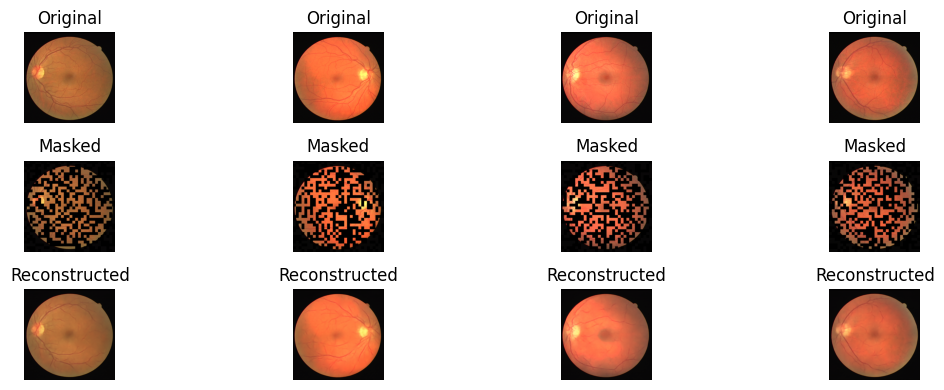

In [16]:
import matplotlib.pyplot as plt

# Put model in evaluation mode
model.eval()
images, _ = next(iter(test_loader))
images = images.to(device)
with torch.no_grad():
    reconstructed, masked_img = model(images)
# Move images back to CPU for visualization
images = images.cpu()
reconstructed = reconstructed.cpu()
masked_img = masked_img.cpu()
# Plot original, masked, and reconstructed images
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(3, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(3, 4, i+5)
    plt.imshow(masked_img[i].permute(1, 2, 0))
    plt.title("Masked")
    plt.axis('off')

    plt.subplot(3, 4, i+9)
    plt.imshow(reconstructed[i].permute(1, 2, 0))
    plt.title("Reconstructed")
    plt.axis('off')
plt.tight_layout()
# plt.show()
plt.savefig('wow.png')